# Description:
To be done

### Imports

In [1]:
#import argparse
#from array import array
import glob
import math
import numpy as np
import os
import ROOT
from ROOT import TCanvas, TFile, TProfile, TNtuple, TH1F, TH2F, TH3F, TH1, TLine
#from ROOT import gROOT, gBenchmark, gRandom, gSystem, Double, gStyle
import scipy
from scipy import stats
import time

Welcome to JupyROOT 6.22/02


### ROOT Batch Mode

In [2]:
# ROOT.gROOT.SetBatch(1)

### Paths

In [3]:
# ============================================================
# Set paths
# ============================================================
datapath = '/data/SingleModule_Nov2020/LArPix/dataRuns/rootTrees/combined_with_light/chargeLight_study_roman'
print(' datapath:   ', datapath)

outputpath = '/home/lhep/PACMAN/larpix-analysis/lightCharge_anticorrelation'
print(' outputpath: ', outputpath)

files = sorted([os.path.basename(path) for path in glob.glob(datapath+'/*.root')])
print(' datafiles (', len(files), '): ')
for f in files:
    print('              ', f)

 datapath:    /data/SingleModule_Nov2020/LArPix/dataRuns/rootTrees/combined_with_light/chargeLight_study_roman
 outputpath:  /home/lhep/PACMAN/larpix-analysis/lightCharge_anticorrelation
 datafiles ( 22 ): 
               sync_wLightReco_20201129_122204.root
               sync_wLightReco_20201129_122655.root
               sync_wLightReco_20201129_130449.root
               sync_wLightReco_20201129_134857.root
               sync_wLightReco_20201129_143427.root
               sync_wLightReco_20201129_150749.root
               sync_wLightReco_20201129_155227.root
               sync_wLightReco_20201129_162434.root
               sync_wLightReco_20201129_170918.root
               sync_wLightReco_20201129_174140.root
               sync_wLightReco_20201129_182214.root
               sync_wLightReco_20201129_185437.root
               sync_wLightReco_20201129_193550.root
               sync_wLightReco_20201129_200721.root
               sync_wLightReco_20201129_204607.root
             

### Define voxelisation

In [4]:
# ============================================================
# Define voxelisation
# ============================================================
n_pixels_x = 70
n_pixels_y = 70
n_pixels_z = 70
pitch_x = 4.434
pitch_y = 4.434
pitch_z = 4.434
pixels_x_min = - pitch_x * n_pixels_x/2. #-155.19
pixels_x_max =   pitch_x * n_pixels_x/2. # 155.19
pixels_y_min = - pitch_y * n_pixels_y/2. #-155.19
pixels_y_max =   pitch_y * n_pixels_y/2. # 155.19
pixels_z_min = 0.
pixels_z_max = n_pixels_z*pitch_z*10 # factor 10 for correction... TODO: CHANGE THIS FOR NEXT PRODUCTION!!

### Define which plots to make

In [5]:
plot_all                                        = True

plot_chargeYield_vs_hitPosX                     = False
plot_chargeYield_vs_hitPosX_summary             = False
plot_chargeYield_vs_eField                      = False
plot_chargeYieldPerHit_vs_eField                = True
plot_totalChargeYield_vs_eField                 = True
plot_detectedLight                              = True
plot_trackLength                                = False
plot_nHits                                      = False
plot_q_raw_tot                                  = False
plot_q_corr_tot                                 = False
plot_dQdl                                       = False
plot_startPosY_vs_startPosX                     = False
plot_endPosY_vs_endPosX                         = False
plot_startPosZ_vs_endPosZ                       = False
plot_nHits_vs_trackLength                       = False
plot_theta_vs_spread_x                          = False
plot_theta_vs_spread_x                          = False
plot_phi_vs_spread_x                            = False
plot_3D_graviCentre                             = False
plot_graviCentre_projection_xy                  = False
plot_graviCentre_projection_xz                  = False
plot_graviCentre_projection_yz                  = False
plot_detectedLight_vs_graviCentre_x             = True
plot_detectedLight_vs_graviCentre_x_SimCorr     = True
plot_detectedLight_vs_graviCentre_x_Selection   = True
plot_detectedLight_vs_graviCentre_x_ProfilePlot = True
plot_detectedLight_vs_track_GCx                 = True

### Make a single TChain with input files

In [6]:
'''
#inputFileName = files[0]
inputFileName = 'sync_wLightReco_20201129_122204.root'
print(' Processing file', inputFileName)

input_tree = ROOT.TChain("t_out", "t_out")
input_tree.Add(datapath + '/' + inputFileName)
#for root_file in config["data_files"]:
#    input_tree.Add(root_file)
#input_tree.Add( "/path/to.root" )

# Turn on all branches of input tree
input_tree.SetBranchStatus("*",           1)
'''
print('Done.')

Done.


### Make List of TChains
Note: Make for every file a separate TChain.
Could substitute >1 files to a single TChain, but then it is more complicated to apply the electron lifetime correction...

In [7]:
#inputFileName = files[20]
#inputFileName = 'sync_wLightReco_20201129_122204.root'
#print(' Processing file', inputFileName)

input_tree_list       = []
eField_intensity_list = [] # [kV/cm]

'''
for i in range(10):
    input_tree = ROOT.TChain("t_out", "t_out")
    
    if i == 0: # 0.1 kV/cm
        input_tree.Add(datapath + '/sync_wLightReco_20201130_002722.root')
        input_tree.Add(datapath + '/sync_wLightReco_20201130_005847.root')
        eField_intensity_list.append(0.1)
    if i == 1: # 0.2 kV/cm
        input_tree.Add(datapath + '/sync_wLightReco_20201129_230700.root')
        input_tree.Add(datapath + '/sync_wLightReco_20201129_234000.root')
        eField_intensity_list.append(0.2)
    if i == 2: # 0.3 kV/cm
        input_tree.Add(datapath + '/sync_wLightReco_20201129_215550.root')
        input_tree.Add(datapath + '/sync_wLightReco_20201129_222751.root')
        eField_intensity_list.append(0.3)
    if i == 3: # 0.4 kV/cm
        input_tree.Add(datapath + '/sync_wLightReco_20201129_204607.root')
        input_tree.Add(datapath + '/sync_wLightReco_20201129_211819.root')
        eField_intensity_list.append(0.4)
    if i == 4: # 0.5 kV/cm
        input_tree.Add(datapath + '/sync_wLightReco_20201129_193550.root')
        input_tree.Add(datapath + '/sync_wLightReco_20201129_200721.root')
        eField_intensity_list.append(0.5)
    if i == 5: # 0.6 kV/cm
        input_tree.Add(datapath + '/sync_wLightReco_20201129_182214.root')
        input_tree.Add(datapath + '/sync_wLightReco_20201129_185437.root')
        eField_intensity_list.append(0.6)
    if i == 6: # 0.7 kV/cm
        input_tree.Add(datapath + '/sync_wLightReco_20201129_170918.root')
        input_tree.Add(datapath + '/sync_wLightReco_20201129_174140.root')
        eField_intensity_list.append(0.7)
    if i == 7: # 0.8 kV/cm
        input_tree.Add(datapath + '/sync_wLightReco_20201129_155227.root')
        input_tree.Add(datapath + '/sync_wLightReco_20201129_162434.root')
        eField_intensity_list.append(0.8)
    if i == 8: # 0.9 kV/cm
        input_tree.Add(datapath + '/sync_wLightReco_20201129_143427.root')
        input_tree.Add(datapath + '/sync_wLightReco_20201129_150749.root')
        eField_intensity_list.append(0.9)
    if i == 9: # 1.0 kV/cm
        input_tree.Add(datapath + '/sync_wLightReco_20201129_122204.root')
        input_tree.Add(datapath + '/sync_wLightReco_20201129_122655.root')
        input_tree.Add(datapath + '/sync_wLightReco_20201129_130449.root')
        input_tree.Add(datapath + '/sync_wLightReco_20201129_134857.root')
        eField_intensity_list.append(1.0)
    
    # Turn on all branches of input tree
    input_tree.SetBranchStatus("*",           1)
    
    # Append input_tree TChain to the input_tree_list
    input_tree_list.append(input_tree)
'''

for i in range(len(files)):
    input_tree = ROOT.TChain("t_out", "t_out")
    #print(' files[',i,']: ', files[i])
    
    if files[i] == 'sync_wLightReco_20201130_002722.root' or\
       files[i] == 'sync_wLightReco_20201130_005847.root':
        input_tree.Add(datapath + '/' + files[i])
        eField_intensity_list.append(0.1)
    if files[i] == 'sync_wLightReco_20201129_230700.root' or\
       files[i] == 'sync_wLightReco_20201129_234000.root':
        input_tree.Add(datapath + '/' + files[i])
        eField_intensity_list.append(0.2)
    if files[i] == 'sync_wLightReco_20201129_215550.root' or\
       files[i] == 'sync_wLightReco_20201129_222751.root':
        input_tree.Add(datapath + '/' + files[i])
        eField_intensity_list.append(0.3)
    if files[i] == 'sync_wLightReco_20201129_204607.root' or\
       files[i] == 'sync_wLightReco_20201129_211819.root':
        input_tree.Add(datapath + '/' + files[i])
        eField_intensity_list.append(0.4)
    if files[i] == 'sync_wLightReco_20201129_193550.root' or\
       files[i] == 'sync_wLightReco_20201129_200721.root':
        input_tree.Add(datapath + '/' + files[i])
        eField_intensity_list.append(0.5)
    if files[i] == 'sync_wLightReco_20201129_182214.root' or\
       files[i] == 'sync_wLightReco_20201129_185437.root':
        input_tree.Add(datapath + '/' + files[i])
        eField_intensity_list.append(0.6)
    if files[i] == 'sync_wLightReco_20201129_170918.root' or\
       files[i] == 'sync_wLightReco_20201129_174140.root':
        input_tree.Add(datapath + '/' + files[i])
        eField_intensity_list.append(0.7)
    if files[i] == 'sync_wLightReco_20201129_155227.root' or\
       files[i] == 'sync_wLightReco_20201129_162434.root':
        input_tree.Add(datapath + '/' + files[i])
        eField_intensity_list.append(0.8)
    if files[i] == 'sync_wLightReco_20201129_143427.root' or\
       files[i] == 'sync_wLightReco_20201129_150749.root':
        input_tree.Add(datapath + '/' + files[i])
        eField_intensity_list.append(0.9)
    if files[i] == 'sync_wLightReco_20201129_122204.root' or\
       files[i] == 'sync_wLightReco_20201129_122655.root' or\
       files[i] == 'sync_wLightReco_20201129_130449.root' or\
       files[i] == 'sync_wLightReco_20201129_134857.root':
        input_tree.Add(datapath + '/' + files[i])
        eField_intensity_list.append(1.0)
    
    # Turn on all branches of input tree
    input_tree.SetBranchStatus("*",           1)
    
    # Append input_tree TChain to the input_tree_list
    input_tree_list.append(input_tree)
    
n_field_intensities = len(np.unique(eField_intensity_list))
print('Number of different field intensities: ', n_field_intensities)
    
print('List with input trees: ')
for i in range(len(input_tree_list)):
    print('   ', eField_intensity_list[i], 'kV/cm: \t [', input_tree_list[i], '] \t (', input_tree_list[i].GetEntries(), 'entries )')
    
print('Done.')

Number of different field intensities:  10
List with input trees: 
    1.0 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 1807 entries )
    1.0 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 19770 entries )
    1.0 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 19234 entries )
    1.0 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 19520 entries )
    0.9 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 19657 entries )
    0.9 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 19369 entries )
    0.8 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 19261 entries )
    0.8 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 18800 entries )
    0.7 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 19185 entries )
    0.7 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 18178 entries )
    0.6 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 18720 entries )
    0.6 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 18202 entries )
    0.5 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 18086 entries )
    0.5 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 18149 entries )
    0.4 kV

### Create directories for plots

In [8]:
'''
# If make_plots: Create corresponding folder
make_plots = True

if make_plots:
    plot_folder = inputFileName[16:-5]
    os.system('rm -rf plots/' + str(plot_folder))
    os.system('mkdir plots/' + str(plot_folder))
    os.system('mkdir plots/' + str(plot_folder) + '/eventDisplays')
'''
for i in range(len(eField_intensity_list)):
    plot_folder = str(eField_intensity_list[i]) + '_kV_per_cm'
    os.system('rm -rf plots/' + str(plot_folder))
    os.system('mkdir plots/' + str(plot_folder))
    os.system('mkdir plots/' + str(plot_folder) + '/eventDisplays')
print('Done.')

Done.


### Define track selection cuts

In [9]:
# Define selection cuts for events
cut_ntracks      = 1    # Only consider events with number of reconstructed tracks == cut_ntracks
cut_lenght       = 250. # Track minimum length [mm]
cut_throughgoing = 130. # |max(track_start_y,track_end_y)| and |min(track_start_y,track_end_y)| must be greater than cut_throughgoing [mm] (tracks must start/end ad absolute y position > 130 mm, closer than ~2.5 cm from edge)
cut_phi          = 20.  # degrees (theta is +/- 90 deg if track is parallel to y-plane / x=const.)
#cut_nhits        = 50.  # Min. number of hits in the track [-]
#cut_residual2    = 3.   # Maximum allowed sqrt(res_x**2+res_y**2+res_z**2), in order to only allow tracks which are 'track-like' with a small spread

# Define selection cuts for single charge hits
cut_hit_x_min    = -141.888 # do not take into account the first 3 pixels rows closest to the LCM modules (they have less charge and light yield).

#TODO:
# CUT ON ANGLE (THETA?) -> THETA? MUST BE CLOSE TO ZERO IN ORDER TO HAVE ALMOST VERTICAL TRACKS

### Define electron drift velocities and lifetimes for every TChain

In [10]:
# Make lists with electron drift velocities and lifetimes
eDrift_vel     = [] # drift velocities [mm/us]
eLifetimes     = [] # one float for every TChain. Lifetime in [us]
eLifetimes_err = [] # one float for every TChain. Lifetime uncertainty in [us]

eLifetime_file = '../electron_lifetime/eLifetimes.txt'
try:
    file1 = open(eLifetime_file, 'r')
    lines = file1.readlines()
    file1.close()
except:
    print(' File '+str(eLifetime_file)+' not found...')

for chain in range(len(input_tree_list)):
    if   eField_intensity_list[chain] == 0.1: eDrift_vel.append(0.535)
    elif eField_intensity_list[chain] == 0.2: eDrift_vel.append(0.933)
    elif eField_intensity_list[chain] == 0.3: eDrift_vel.append(1.230)
    elif eField_intensity_list[chain] == 0.4: eDrift_vel.append(1.461)
    elif eField_intensity_list[chain] == 0.5: eDrift_vel.append(1.648)
    elif eField_intensity_list[chain] == 0.6: eDrift_vel.append(1.806)
    elif eField_intensity_list[chain] == 0.7: eDrift_vel.append(1.941)
    elif eField_intensity_list[chain] == 0.8: eDrift_vel.append(2.060)
    elif eField_intensity_list[chain] == 0.9: eDrift_vel.append(2.166)
    elif eField_intensity_list[chain] == 1.0: eDrift_vel.append(2.261)
    else:
        print(' WARNING: No eDrift velocity defined for eField intensity =', eField_intensity_list[chain], 'kV/cm ...')
        eDrift_vel.append(9999.9)
    
    eLifetime_assigned = False
    for line in lines:
        if eLifetime_assigned:
            break
        L = line.split(',')
        if str(L[0]) == str(files[chain][16:-5]):
            #if str(L[0]) in ['20201130_002722',\
            #                 '20201130_005847',\
            #                 '20201129_230700',\
            #                 '20201129_234000',\
            #                 '20201129_215550',\
            #                 '20201129_222751']:
            #    eLifetimes.append(2000.)
            #    eLifetimes_err.append(2000.)
            #    eLifetime_assigned = True
            #else:
            #    eLifetimes.append(float(L[1]))
            #    eLifetimes_err.append(float(L[2]))
            #    eLifetime_assigned = True
            eLifetimes.append(float(L[1]))
            eLifetimes_err.append(float(L[2]))
            eLifetime_assigned = True
        #else:
        #    print(' WARNING: eLifetime for ', files[chain], ' not found in file ', eLifetime_file)
    if not eLifetime_assigned:
        print(' WARNING: eLifetime for file', files[chain], 'not found in file ', eLifetime_file)
        print('          --> Setting it to 4.0 us +/- 4.0 us ...')
        eLifetimes.append(4000.)
        eLifetimes_err.append(4000.)
    
    #eLifetimes.append(2.0) # TODO: Put here the proper lifetimes!
    
    
print('\n File summary: ')
for i in range(len(input_tree_list)):
    print('    file', i, ':\t', files[i],\
          '\t E-field: ', eField_intensity_list[i],\
          'kV/cm \t eLifetime: ', round(eLifetimes[i],2),\
          'us +/- : ', round(eLifetimes_err[i],2),\
          'us \t eDrift: ', round(eDrift_vel[i],2), 'mm/us')    
    
print('Done.')


 File summary: 
    file 0 :	 sync_wLightReco_20201129_122204.root 	 E-field:  1.0 kV/cm 	 eLifetime:  1426.94 us +/- :  504.91 us 	 eDrift:  2.26 mm/us
    file 1 :	 sync_wLightReco_20201129_122655.root 	 E-field:  1.0 kV/cm 	 eLifetime:  1340.49 us +/- :  164.27 us 	 eDrift:  2.26 mm/us
    file 2 :	 sync_wLightReco_20201129_130449.root 	 E-field:  1.0 kV/cm 	 eLifetime:  1375.7 us +/- :  183.11 us 	 eDrift:  2.26 mm/us
    file 3 :	 sync_wLightReco_20201129_134857.root 	 E-field:  1.0 kV/cm 	 eLifetime:  1080.22 us +/- :  125.05 us 	 eDrift:  2.26 mm/us
    file 4 :	 sync_wLightReco_20201129_143427.root 	 E-field:  0.9 kV/cm 	 eLifetime:  1502.47 us +/- :  246.33 us 	 eDrift:  2.17 mm/us
    file 5 :	 sync_wLightReco_20201129_150749.root 	 E-field:  0.9 kV/cm 	 eLifetime:  1331.27 us +/- :  144.44 us 	 eDrift:  2.17 mm/us
    file 6 :	 sync_wLightReco_20201129_155227.root 	 E-field:  0.8 kV/cm 	 eLifetime:  2199.73 us +/- :  279.75 us 	 eDrift:  2.06 mm/us
    file 7 :	 sync_wLight

### Loop over all TChains in input_tree_list

In [11]:
# Progress bar
from IPython.display import HTML, display

def progress(count, total, unit, message=''):
    return HTML("""
        <progress 
            value='{count}'
            max='{total}',
            style='width: 30%'
        >
            {count}
        </progress> {count}/{total} {unit} ({frac}%) ... {message}
    """.format(count=count, total=total, unit=unit, frac=int(float(count)/float(total)*100.),message=message))

print('Done.')

Done.


In [12]:
e_field_list            = []
e_field_errors_list     = []
track_length_list       = []
track_n_hits_list       = []
track_start_pos_x_list  = []
track_start_pos_y_list  = []
track_start_pos_z_list  = []
track_end_pos_x_list    = []
track_end_pos_y_list    = []
track_end_pos_z_list    = []
track_spread_x_list     = []
track_theta_list        = []
track_phi_list          = []
LCM_detectedLight_list  = []
track_q_raw_tot_list    = []
track_q_corr_tot_list   = []
track_q_corr_tot_err_list = []
track_q_corr_in_GC_bin  = [] # containing n (=number of E-field intensities) lists with m (=number of gravicentres) q_corr values
pixels_chargeYield_list = [] # containing n (=number of E-field intensities) lists with m (=number of gravicentres) lists
pixels_hits_x_list      = []
pixels_hits_q_corr_list = []
track_cgx_list          = []
track_cgy_list          = []
track_cgz_list          = []

In [13]:
# Uncertainties on electric field intensity
# uncertainty on HV = 0.05 kV (display shows 0.1 kV units), with max. drift distance = 30.2 cm +/- 0.2 cm
# -> uncertainty on EField = sqrt((1./30.2*0.05)^2 + (U/(drift_dist_max*2)*0.1)**2) kV/cm
HV_voltages = [3.065, 6.073,9.082, 12.034, 15.1, 18.107, 21.173, 24.124, 27.19, 30.198]
drift_dist_max = 30.2
delta_drift_dist = 0.2
delta_HV = 0.05
e_field_errors_list = [np.sqrt(delta_HV**2/(drift_dist_max**2)+math.pow(HV_voltages[i]/(drift_dist_max**2)*delta_drift_dist,2)) for i in range(n_field_intensities)]
print(' e_field_errors_list: ', e_field_errors_list)

 e_field_errors_list:  [0.0017868555234909502, 0.0021247679489445697, 0.0025898833990820784, 0.0031152854056979403, 0.003702099300496341, 0.0043020044377812235, 0.00492935485980149, 0.0055431457982095846, 0.006188053870739866, 0.006825908335641544]


In [14]:
out = display(progress(0,n_field_intensities,'E-field intensities processed'),display_id=True)
start = time.time()

for eField in range(n_field_intensities):
    field_intensity = (eField+1)/10.
    
    #if not (field_intensity == 0.5 or field_intensity == 0.6):
    #    continue
    
    print( ' ----------------------------------------------------------------------------------- ')
    print(' Processing chains with field_intensity: ', field_intensity, 'kV/cm')
    
    # Define lists with interesting quantities
    track_length         = [] # Reconstructed track's length [mm]
    track_n_hits         = [] # Reconstructed track's total number of hits [-]
    track_start_pos_x    = [] # Reconstructed track's start position coordinates x [mm]
    track_start_pos_y    = [] # Reconstructed track's start position coordinates y [mm]
    track_start_pos_z    = [] # Reconstructed track's start position coordinates z [mm]
    track_end_pos_x      = [] # Reconstructed track's end position coordinates x [mm]
    track_end_pos_y      = [] # Reconstructed track's end position coordinates y [mm]
    track_end_pos_z      = [] # Reconstructed track's end position coordinates z [mm]
    track_spread_x       = [] # Reconstructed track's start_x-end_x [mm]
    track_theta          = [] # Reconstructed track's theta ('direction') [rad]
    track_phi            = [] # Reconstructed track's phi ('direction') [rad]
    LCM_detectedLight    = [] # Total detected number of photo electrons by all 6 LCM SiPMs
    #LCM_producedLight    = [] # Total reconstructed number of photons by the track (note: there is a bug in Livio's acceptance calculation...)
    track_q_raw_tot      = [] # Reconstructed track's total charge deposit [ke] (no eLifetime correction)
    track_q_corr_tot     = [] # Reconstructed track's total charge deposit [ke] (eLifetime corrected)
    track_q_corr_tot_err = [] # Systematic uncertainty on the corrected track's total charge (only taking into account the electron lifetime)
    pixels_chargeYield   = [] # Reconstructed charge on pixels for every GC bin [ke] (eLifetime corrected)
    pixels_hits_x        = []
    pixels_hits_q_corr   = []
    track_cgx            = [] # gravicentre of the track (weighted by hits_q, but NOT YET ELECTRON LIFETIME CORRECTED -> TODO)
    track_cgy            = [] # gravicentre of the track (weighted by hits_q, but NOT YET ELECTRON LIFETIME CORRECTED -> TODO)
    track_cgz            = [] # gravicentre of the track (weighted by hits_q, but NOT YET ELECTRON LIFETIME CORRECTED -> TODO)
    
    
    for chain in range(len(input_tree_list)):
        
        # Skip the first two files (in order to have ~ the same statistics for all eField intensities):
        if chain == 0 or chain == 1:
            continue
            
        #if chain not in [5]:
        #    continue
        
        if eField_intensity_list[chain] != field_intensity:
            continue
        print('     Chain Nr.', chain)
        print('         eField [kV/cm]:     ', eField_intensity_list[chain], '+/-', round(e_field_errors_list[int(eField_intensity_list[chain]*10-1)],5))
        print('         eLifetime [us]:     ', eLifetimes[chain], '+/-', eLifetimes_err[chain])
        print('         eDrift_vel [mm/us]: ', eDrift_vel[chain])

        # Number of tracks in the TChain
        n_tracks = input_tree_list[chain].GetEntries()
        print('         Number of tracks : ', n_tracks)

        #print(input_tree_list[chain].Print())

        # List for events with a low light detection
        #low_light_events = []

        # List for track selection
        #selected_trackIDs = []

        accepted_tracks_counter = 0
        
        # Loop over all tracks in input_tree
        for track_id in range(n_tracks):
            if(track_id%10000==0):
                now = time.time()
                print('             Processed', track_id, 'of', n_tracks, 'tracks. \t Elapsed time:', math.ceil(now-start), ' seconds ... \r')
                
            input_tree_list[chain].GetEntry(track_id)

            # Apply Selection Cuts
            if input_tree_list[chain].t_track_length < cut_lenght:
                continue
            if input_tree_list[chain].t_event_ntracks > cut_ntracks:
                continue
            if abs(max(input_tree_list[chain].t_track_start_pos_y,input_tree_list[chain].t_track_end_pos_y)) < cut_throughgoing or\
               abs(min(input_tree_list[chain].t_track_start_pos_y,input_tree_list[chain].t_track_end_pos_y)) < cut_throughgoing:
                #print(input_tree_list[chain].t_track_start_pos_y)
                #print(input_tree_list[chain].t_track_end_pos_y)
                #print(' ---------------- ')
                continue
            
            if abs(input_tree_list[chain].t_track_phi*180./np.pi) < (90.-cut_phi) or abs(input_tree_list[chain].t_track_phi*180./np.pi) > (90.+cut_phi):
                continue

            #if track_id > 500:
            #    break

            #selected_trackIDs.append(input_tree_list[chain].t_trackID)

            #if track_id > 15:
            #    break

            '''        
            print(' ----------------------------------------- ')
            #print(' t_eventID:           ', input_tree_list[chain].t_eventID)
            print(' t_trackID:           ', input_tree_list[chain].t_trackID)
            #print(' t_event_q:           ', input_tree_list[chain].t_event_q)
            print(' t_track_length:      ', input_tree_list[chain].t_track_length)
            print(' t_event_ntracks:     ', input_tree_list[chain].t_event_ntracks)
            print(' t_track_start_pos_y: ', input_tree_list[chain].t_track_start_pos_y)
            print(' t_track_end_pos_y:   ', input_tree_list[chain].t_track_end_pos_y)
            #print(' t_track_q:           ', input_tree_list[chain].t_track_q)
            #print(' t_event_nhits:       ', input_tree_list[chain].t_event_nhits)
            #print(' t_track_nhits:       ', input_tree_list[chain].t_track_nhits)
            #print(' t_tlcm1_tot:         ', input_tree_list[chain].l_tlcm1_tot)
            '''
            
            # For low light events
            #if input_tree_list[chain].l_tlcm1_tot<150:
            #    low_light_events.append(input_tree_list[chain].t_trackID)

            # Obtain the track's total charge and its center of gravity (weighted by deposited charge)
            # Loop over all hits
            q_raw_tot            = 0.
            q_corr_tot           = 0.
            q_corr_tot_errorTerm = 0.
            cgx                  = 0.
            cgy                  = 0.
            cgz                  = 0.
            counter_hits         = 0
            for hit in range(input_tree_list[chain].t_track_nhits):
                if input_tree_list[chain].t_track_hits_x[hit] <= cut_hit_x_min:
                    continue
                counter_hits += 1
                #if hit>2:
                #    break
                
                q_corr_factor = np.exp(0.1*input_tree_list[chain].t_track_hits_z[hit]/(eDrift_vel[chain]*eLifetimes[chain])) # TODO: factor 0.1 due to factor 10 problem -> fix it
                #print(' hit_z [mm]:    ', 0.1 * input_tree_list[chain].t_track_hits_z[hit]) # TODO: factor 0.1 due to factor 10 problem -> fix it
                #print(' q_corr_factor: ', q_corr_factor)
                q_raw_tot += input_tree_list[chain].t_track_hits_q[hit]
                hit_q_corr = input_tree_list[chain].t_track_hits_q[hit] * q_corr_factor # q_corr_factor corrects for the electron lifetime
                q_corr_tot += hit_q_corr
                q_corr_tot_errorTerm += hit_q_corr * (0.1*input_tree_list[chain].t_track_hits_z[hit]/(eDrift_vel[chain]*eLifetimes[chain]**2))
                
                ### print(' hit_x:  ', input_tree_list[chain].t_track_hits_x[hit], ' \t hit_q_corr: ', hit_q_corr)
                
                cgx += input_tree_list[chain].t_track_hits_x[hit]*hit_q_corr
                cgy += input_tree_list[chain].t_track_hits_y[hit]*hit_q_corr
                cgz += 0.1 * input_tree_list[chain].t_track_hits_z[hit]*hit_q_corr # TODO: factor 0.1 due to factor 10 problem -> fix it
                
                pixels_hits_x.append(input_tree_list[chain].t_track_hits_x[hit])
                pixels_hits_q_corr.append(hit_q_corr)
            
            if q_raw_tot > 0.:
                track_q_raw_tot.append(q_raw_tot)
                track_q_corr_tot.append(q_corr_tot)
                pixels_chargeYield.append(q_corr_tot)
                # normalize gravicentre
                gravicentre_x = cgx/(q_corr_tot)
                gravicentre_y = cgy/(q_corr_tot)
                gravicentre_z = cgz/(q_corr_tot)
                track_cgx.append(gravicentre_x)
                track_cgy.append(gravicentre_y)
                track_cgz.append(gravicentre_z)
                #print(' ------------------------------ ')
                #print(' t_trackID:     ', input_tree_list[chain].t_trackID)
                #print(' cgx:           ', gravicentre_x)
                #print(' cgy:           ', gravicentre_y)
                #print(' cgz:           ', gravicentre_z)
                #print(' pixels_chargeYield:   ', pixels_chargeYield[-1])
                
                q_corr_err = math.sqrt( (q_corr_tot_errorTerm/counter_hits)**2 * eLifetimes_err[chain]**2 )
                #print(' q_corr_tot: ', q_corr_tot)
                #print(' n_hits: ', len(pixels_hits_q_corr))
                #print(' q_corr_perHit: ', q_corr_tot/counter_hits, '+/-', q_corr_err)
                track_q_corr_tot_err.append(q_corr_err)
                
                track_length.append(input_tree_list[chain].t_track_length)
                track_n_hits.append(input_tree_list[chain].t_track_nhits)
                #track_q_tot.append(input_tree_list[chain].t_track_q) # this needs to be corrected by the electron lifetime (see below)

                track_start_pos_x.append(input_tree_list[chain].t_track_start_pos_x)
                track_start_pos_y.append(input_tree_list[chain].t_track_start_pos_y)
                track_start_pos_z.append(input_tree_list[chain].t_track_start_pos_z)
                track_end_pos_x.append(input_tree_list[chain].t_track_end_pos_x)
                track_end_pos_y.append(input_tree_list[chain].t_track_end_pos_y)
                track_end_pos_z.append(input_tree_list[chain].t_track_end_pos_z)

                track_spread_x.append(input_tree_list[chain].t_track_start_pos_x-input_tree_list[chain].t_track_end_pos_x)
                track_theta.append(input_tree_list[chain].t_track_theta)
                track_phi.append(input_tree_list[chain].t_track_phi)

                LCM_detectedLight.append(input_tree_list[chain].l_tlcm1_tot)
                #LCM_producedLight.append(input_tree_list[chain].t_lcm1)

    e_field_list.append(field_intensity)
    track_length_list.append(track_length)
    track_n_hits_list.append(track_n_hits)
    track_q_raw_tot_list.append(track_q_raw_tot)
    track_q_corr_tot_list.append(track_q_corr_tot)
    track_q_corr_tot_err_list.append(track_q_corr_tot_err)
    track_start_pos_x_list.append(track_start_pos_x)
    track_start_pos_y_list.append(track_start_pos_y)
    track_start_pos_z_list.append(track_start_pos_z)
    track_end_pos_x_list.append(track_end_pos_x)
    track_end_pos_y_list.append(track_end_pos_y)
    track_end_pos_z_list.append(track_end_pos_z)
    track_spread_x_list.append(track_spread_x)
    track_theta_list.append(track_theta)
    track_phi_list.append(track_phi)
    LCM_detectedLight_list.append(LCM_detectedLight)
    #LCM_producedLight_list.append(LCM_producedLight)
    pixels_chargeYield_list.append(pixels_chargeYield)
    track_cgx_list.append(track_cgx)
    track_cgy_list.append(track_cgy)
    track_cgz_list.append(track_cgz)
    pixels_hits_x_list.append(pixels_hits_x)
    pixels_hits_q_corr_list.append(pixels_hits_q_corr)
    
    #print(' Number of selected tracks: ', len(selected_trackIDs))

    out.update(progress(eField+1,n_field_intensities,'E-field processed'))
out.update(progress(n_field_intensities,n_field_intensities,'E-field processed'))
print(' Done.')

### print(' pixels_hits_x_list:      ', pixels_hits_x_list)
### print(' pixels_hits_q_corr_list: ', pixels_hits_q_corr_list)

 ----------------------------------------------------------------------------------- 
 Processing chains with field_intensity:  0.1 kV/cm
     Chain Nr. 20
         eField [kV/cm]:      0.1 +/- 0.00179
         eLifetime [us]:      12150.72183462109 +/- 4718.720643545804
         eDrift_vel [mm/us]:  0.535
         Number of tracks :  2068
             Processed 0 of 2068 tracks. 	 Elapsed time: 1  seconds ... 
     Chain Nr. 21
         eField [kV/cm]:      0.1 +/- 0.00179
         eLifetime [us]:      5377.790965655243 +/- 1043.1002396130393
         eDrift_vel [mm/us]:  0.535
         Number of tracks :  1964
             Processed 0 of 1964 tracks. 	 Elapsed time: 1  seconds ... 
 ----------------------------------------------------------------------------------- 
 Processing chains with field_intensity:  0.2 kV/cm
     Chain Nr. 18
         eField [kV/cm]:      0.2 +/- 0.00212
         eLifetime [us]:      5925.085465719896 +/- 1328.2282444099924
         eDrift_vel [mm/us]:  0.93

In [15]:
# Obtain stat. and syst. uncertainties on mean charge deposited per hit
# Note: SEM (standard error of the mean) = stdev / sqrt(n measurements [not nan or inf])
q_corr_per_hit_systErr = []
q_corr_per_hit_statErr = []
for i in range(n_field_intensities):
    #print(' eField: ', (i+1)/10.)
    #print(' track_n_hits_list: ', track_n_hits_list)
    #print(' track_q_corr_tot_list: ', track_q_corr_tot_list)
    #print(' mean charge per hit:  ', np.nanmean(pixels_hits_q_corr_list[i]))
    #print(' q_corr per hit, stat: ', scipy.stats.sem(pixels_hits_q_corr_list[i]))
    q_corr_per_hit_statErr.append(scipy.stats.sem(pixels_hits_q_corr_list[i]))
    err = 0.
    #print(' number of tracks: ', len(track_q_corr_tot_list[i]))
    for k in range(len(track_q_corr_tot_list[i])):
        err += track_q_corr_tot_err_list[i][k]**2
    #print(' q_corr per hit, syst: ', math.sqrt(err)/len(track_q_corr_tot_list[i]))
    q_corr_per_hit_systErr.append(math.sqrt(err)/math.sqrt(len(track_q_corr_tot_list[i])))
    #print(' ===================== ')

print(' q_corr_per_hit_statErr: ', q_corr_per_hit_statErr)
print(' q_corr_per_hit_systErr: ', q_corr_per_hit_systErr)

print('Done.')

 q_corr_per_hit_statErr:  [1.4590518723379875, 0.3915918515195958, 0.1615782997494656, 0.11875919169707727, 0.10032872347542814, 0.09650232574031145, 0.09694903718882714, 0.09237947185189073, 0.09551707627821997, 0.09554492600927128]
 q_corr_per_hit_systErr:  [0.9001183840894732, 0.8732257388990312, 0.5276514727340309, 0.506761826381683, 0.6889465347759851, 1.1708211012296514, 1.2304139434627006, 1.0022217594497376, 1.2807756695838808, 1.3231918413367374]
Done.


### Make Plots for Selected (!) Events

In [16]:
from plot_functions import *

In [17]:
# Plot charge yield per hit as a function of the hit position x

# Define how many graviCentre bins to have:
n_graviCentre_bins = 10
GC_binning = np.linspace(pixels_x_min,pixels_x_max,n_graviCentre_bins+1)

# Define binning
x_err  = []
x_vals = []
bin_width = GC_binning[1]-GC_binning[0]
for ibin in range(n_graviCentre_bins):
    x_err.append(0.5*bin_width)
    x_vals.append(GC_binning[ibin]+0.5*bin_width)

# Obtain chargeYield_perHit data
pixels_q_corr_tot_list        = []
pixels_q_corr_meanPerHit_list = []
pixels_q_corr_sem_list        = []
print(' Obtaining data...')
out = display(progress(0,n_field_intensities,'E-field intensities processed'),display_id=True)
for eField_index in range(n_field_intensities):    
    _q_corr_tot_list    = []
    _q_corr_summed     = []
    _q_corr_meanPerHit = []
    _q_corr_sem        = []
    for GC in range(n_graviCentre_bins):
        _q_corr_tot = []
        for hit in range(len(pixels_hits_x_list[eField_index])):
            if pixels_hits_x_list[eField_index][hit]>GC_binning[GC] and pixels_hits_x_list[eField_index][hit]<GC_binning[GC+1]:
                _q_corr_tot.append(pixels_hits_q_corr_list[eField_index][hit])
        _q_corr_summed.append(np.sum(_q_corr_tot))
        _q_corr_meanPerHit.append(np.mean(_q_corr_tot))
        _q_corr_sem.append(scipy.stats.sem(_q_corr_tot))
    pixels_q_corr_tot_list.append(_q_corr_summed)
    pixels_q_corr_meanPerHit_list.append(_q_corr_meanPerHit)
    pixels_q_corr_sem_list.append(_q_corr_sem)
    out.update(progress(eField_index+1,n_field_intensities,'E-field intensities processed'))
out.update(progress(n_field_intensities,n_field_intensities,'E-field intensities processed'))

# Make plot
print(' Make plots...')
if plot_all or plot_chargeYield_vs_hitPosX:
    out = display(progress(0,n_field_intensities,'E-field intensities processed'),display_id=True)
    for eField_index in range(n_field_intensities):
        #print(pixels_q_corr_meanPerHit_list[eField_index])
        if len(pixels_q_corr_meanPerHit_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        series_label_list = ['CY [ke]','GC x [mm] (scale factor: 1/10)']
        axis_labels = ['Hit position x [mm]','Detected charge per hit [ke]']
        x_min,x_max = pixels_x_min, pixels_x_max
        y_min,y_max = 0,200
        save_name = 'plots/'+str(plot_folder)+'/'+'TGraphError_ChargeYieldPerHit_vs_CoordX.png'
        plot_errorbars(x_vals,pixels_q_corr_meanPerHit_list[eField_index],x_err,pixels_q_corr_sem_list[eField_index],\
                       x_min,x_max,y_min,y_max,\
                       axis_labels,save_name)
        out.update(progress(eField_index+1,n_field_intensities,'E-field intensities processed'))
    out.update(progress(n_field_intensities,n_field_intensities,'E-field intensities processed'))
print('Done.')

 Obtaining data...


/home/roman/software/anaconda3/envs/larpix-analysis-38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/roman/software/anaconda3/envs/larpix-analysis-38/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/roman/software/anaconda3/envs/larpix-analysis-38/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/roman/software/anaconda3/envs/larpix-analysis-38/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/roman/software/anaconda3/envs/larpix-analysis-38/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
 

 Make plots...


/home/roman/software/anaconda3/envs/larpix-analysis-38/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/roman/software/anaconda3/envs/larpix-analysis-38/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


Done.


In [18]:
# Plot charge yield per hit as a function of the hit position x (summary plot)
if plot_all or plot_chargeYield_vs_hitPosX_summary:
    #print(' x_vals: ', x_vals)
    #print(' pixels_q_corr_meanPerHit_list: ', pixels_q_corr_meanPerHit_list)
    #print(' x_err: ', x_err)
    #print(' pixels_q_corr_sem_list: ', pixels_q_corr_sem_list)
    
    x_min,x_max = pixels_x_min, pixels_x_max
    y_min,y_max = 0,200
    
    axis_labels = ['Hit position x [mm]','Charge yield per hit [ke]']
    save_name = 'plots/TGraphError_ChargeYieldPerHit_vs_CoordX_summary.png'
    restrict_to_entries = [2,5,9]
    x_vals_list      = [x_vals for i in range(n_graviCentre_bins)]
    
    plot_folder_list = []
    for eField_index in range(n_field_intensities):
        plot_folder_list.append(str(e_field_list[eField_index]) + '_kV_per_cm')
    
    # Plot charge yield per hit as a function of the hit position x (summary)
    plot_profile_of_2D_hist_00(x_vals_list,pixels_q_corr_meanPerHit_list,x_err,pixels_q_corr_sem_list,\
                               plot_folder_list,\
                               axis_labels,\
                               x_min,x_max,y_min,y_max,\
                               save_name,\
                               restrict_to_entries,\
                               plot_legend=True)
print('Done.')

Done.


 err_tot:  [2.3592 1.2648 0.6892 0.6255 0.7893 1.2673 1.3274 1.0946 1.3763 1.4187]
 Q0_boxModel:    161.27609280553622  +/-  2.3462448720371123
 beta_boxModel:  0.1296680606186559  +/-  0.014248691784553156
 Q0_birksModel:  159.28615525623889  +/-  2.3797489178984903
 k_birksModel:   0.026019214467986343  +/-  0.0029260141973321504


/home/roman/PACMAN/larpix-analysis/lightCharge_anticorrelation/plot_functions.py:652: RuntimeWarning: invalid value encountered in log
  return Q0 * E/beta * np.log(1.+beta/E)


Done.


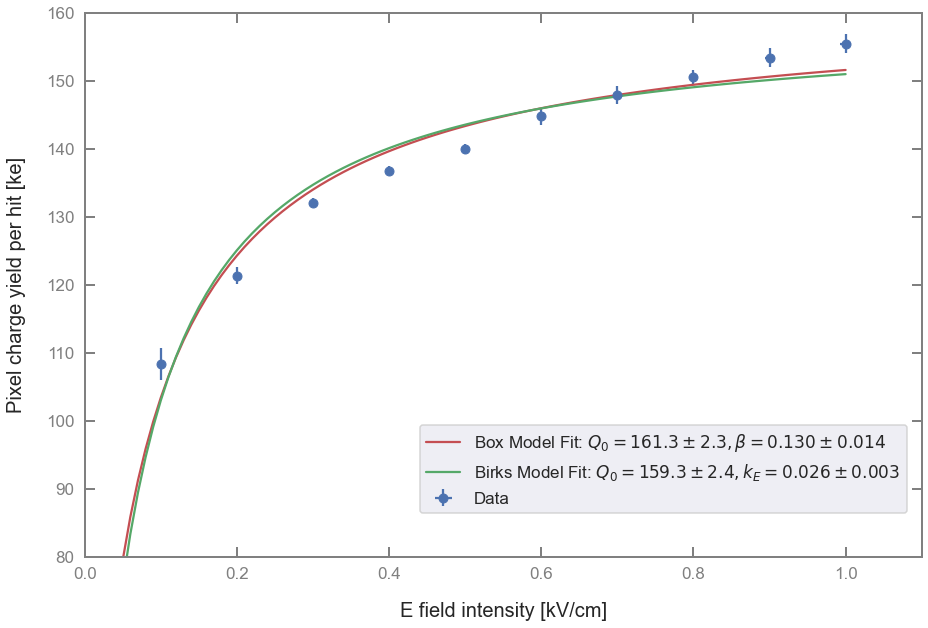

In [19]:
# Plot pixel charge yield per hit as a function of the E-field intensity
np.set_printoptions(precision=4)
if plot_all or plot_chargeYieldPerHit_vs_eField:
    # Obtain chargeYield_perHit data
    q_corr_meanPerHit = []
    q_corr_sem        = []
    for eField_index in range(n_field_intensities):
        q_corr_meanPerHit.append(np.nanmean(pixels_hits_q_corr_list[eField_index]))
        q_corr_sem.append(scipy.stats.sem(pixels_hits_q_corr_list[eField_index]))
    #print(' mean:         ', np.nanmean(pixels_hits_q_corr_list[eField_index]))
    #print(' stdev:        ', np.std(pixels_hits_q_corr_list[eField_index]))
    #print(' stdev/sqrt(n):', np.std(pixels_hits_q_corr_list[eField_index])/np.sqrt(len(pixels_hits_q_corr_list[eField_index])))
    #print(' SEM:          ', scipy.stats.sem(pixels_hits_q_corr_list[eField_index]))

    err_tot = np.array(q_corr_per_hit_systErr) + np.array(q_corr_per_hit_statErr)
    print(' err_tot: ', np.array(err_tot))
    
    # Make plot
    if plot_all or plot_chargeYield_vs_eField:
        x_min, x_max = 0.0, 1.1
        y_min, y_max = 80, 160
        axis_labels = ['E field intensity [kV/cm]','Detected charge per hit [ke]']
        save_name = 'plots/TGraphError_ChargeYieldPerHit_vs_eField.png'
        Q0_box, Q0_box_err, beta_box, beta_box_err,\
        Q0_birks, Q0_birks_err, k_birks, k_birks_err = \
        plot_birksAndBoxModel(e_field_list,q_corr_meanPerHit,e_field_errors_list,err_tot,\
                              x_min,x_max,y_min,y_max,\
                              axis_labels,save_name)
print('Done.')

In [20]:
# Print recombination factor R for different fields
# Note: Q_obs = Q_0 * R

if plot_all or plot_chargeYield_vs_eField:

    #print(Q0_box, Q0_box_err, beta_box, beta_box_err,Q0_birks, Q0_birks_err, k_birks, k_birks_err)

    R_box_list   = []
    R_birks_list = []
    y_err_box    = []
    y_err_birks  = []
    
    series_label_list = ['Box Model','ICARUS Model']
    axis_labels = ['E field intensity [kV/cm]','Charge recombination factor [-]']

    x_min,x_max = 0.0, 1.1
    y_min,y_max = 0.6, 1.0

    save_name = 'plots/TGraphError_recombinationFactors.png'

    for eField in range(n_field_intensities):
        Q_obs = q_corr_meanPerHit[eField]
        R_box = e_field_list[eField]/beta_box*np.log(1.+beta_box/e_field_list[eField])
        R_birks = 1./(1.+k_birks/e_field_list[eField]*2.1) # 2.1 = dE/dx
        #print(' E field:       ', e_field_list[eField], 'kV/cm')
        #print(' Q_obs:         ', Q_obs, '+/-', q_corr_sem[eField])
        #print(' R_box:         ', R_box)
        #print(' R_birks:       ', R_birks)
        R_box_list.append(R_box)
        R_birks_list.append(R_birks)
        y_err_box.append(R_box*np.sqrt(q_corr_sem[eField]**2/Q0_box**2 + Q_obs**2/Q0_box**4*Q0_box_err**2))
        y_err_birks.append(R_birks*np.sqrt(q_corr_sem[eField]**2/Q0_birks**2 + Q_obs**2/Q0_birks**4*Q0_birks_err**2))
        #print(' R_obs_box:     ', q_corr_meanPerHit[eField]/Q0_box)   # Assumes Q_0 from fit!
        #print(' R_obs_birks:   ', q_corr_meanPerHit[eField]/Q0_birks) # Assumes Q_0 from fit!
        ###print(' Q_obs/Q_birks: ', q_corr_meanPerHit[eField]/Q0_birks)
        ###print(' R_obs - R_fit: ', 100*(q_corr_meanPerHit[eField]/Q0_birks - 1./(1.+k_birks/e_field_list[eField])))
        #print(' ------------------------------------------------- ')

    plot_TGraphErr(e_field_list,[R_box_list,R_birks_list],e_field_errors_list,[y_err_box,y_err_birks],series_label_list,axis_labels,x_min,x_max,y_min,y_max,save_name)
print('Done.')

Done.


In [21]:
# Plot total pixel charge yield as a function of the E-field intensity
if plot_all or plot_totalChargeYield_vs_eField:
    # Obtain chargeYield_perHit data
    CY_tot_mean = []
    CY_tot_sem  = []
    for eField_index in range(n_field_intensities):
        CY_tot_mean.append(np.nanmean(track_q_corr_tot_list[eField_index]))
        CY_tot_sem.append(scipy.stats.sem(track_q_corr_tot_list[eField_index]))
    
    x_vals = np.linspace(0.1,1.0,10)

    # Make plot
    if plot_all or plot_chargeYield_vs_eField:
        x_min = 0
        x_max = 1.1
        y_min = 6000
        y_max = 10000
        axis_labels = ['E field intensity [kV/cm]','Detected charge total [ke]']
        save_name = 'plots/TGraphError_totalChargeYield_vs_eField.png'
        #plot_birksAndBoxModel(x_vals,CY_tot_mean,x_err,CY_tot_sem,\
        #                       x_min,x_max,y_min,y_max,\
        #                       axis_labels,save_name)
        plot_errorbars(x_vals,CY_tot_mean,e_field_errors_list,CY_tot_sem,\
                       x_min,x_max,y_min,y_max,\
                       axis_labels,save_name)
print('Done.')

Done.


In [22]:
# LCM_detectedLight
if plot_all or plot_detectedLight:
    out = display(progress(0,n_field_intensities,'E-field intensities processed'),display_id=True)
    for eField_index in range(n_field_intensities):
        #print(LCM_detectedLight_list[eField_index])
        if len(LCM_detectedLight_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        x_min  = np.min(LCM_detectedLight_list[eField_index])
        x_max  = np.max(LCM_detectedLight_list[eField_index])
        n_bins = 50
        axis_labels = ['LCM detected light [p.e.]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h1_LCM_detectedLight.png'
        plot_h1(LCM_detectedLight_list[eField],x_min,x_max,n_bins,axis_labels,save_name)
        out.update(progress(eField_index+1,n_field_intensities,'E-field intensities processed'))
    out.update(progress(n_field_intensities,n_field_intensities,'E-field intensities processed'))
print('Done.')

Done.


In [23]:
# Track Length
if plot_all or plot_trackLength:
    out = display(progress(0,n_field_intensities,'E-field intensities processed'),display_id=True)
    for eField_index in range(n_field_intensities):
        #print(track_length_list[eField_index])
        if len(track_length_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        x_min  = 0
        x_max  = np.max(track_length_list[eField_index])
        n_bins = 50
        axis_labels = ['Track length [mm]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h1_track_lengths.png'
        plot_h1(track_length_list[eField_index],x_min,x_max,n_bins,axis_labels,save_name)
        out.update(progress(eField_index+1,n_field_intensities,'E-field intensities processed'))
    out.update(progress(n_field_intensities,n_field_intensities,'E-field intensities processed'))
print('Done.')

Done.


In [24]:
# Track n_hits
if plot_all or plot_nHits:
    out = display(progress(0,n_field_intensities,'E-field intensities processed'),display_id=True)
    for eField_index in range(n_field_intensities):
        #print(track_n_hits_list[eField_index])
        if len(track_n_hits_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        x_min  = 0
        x_max  = np.max(track_n_hits_list[eField_index])
        n_bins = 50
        axis_labels = ['Number of hits per track [-]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h1_track_nhits.png'
        plot_h1(track_n_hits_list[eField_index],x_min,x_max,n_bins,axis_labels,save_name)
        out.update(progress(eField_index+1,n_field_intensities,'E-field intensities processed'))
    out.update(progress(n_field_intensities,n_field_intensities,'E-field intensities processed'))
print('Done.')

Done.


In [25]:
# Track q_raw_tot
if plot_all or plot_q_raw_tot:
    out = display(progress(0,n_field_intensities,'E-field intensities processed'),display_id=True)
    for eField_index in range(n_field_intensities):
        #print(track_q_raw_tot_list[eField_index])
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        x_min  = 0
        x_max  = 20000 #np.max(track_q_raw_tot_list[eField_index])
        n_bins = 50
        axis_labels = ['Total deposited charge (raw) [ke]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h1_track_q_raw_tot.png'
        plot_h1(track_q_raw_tot_list[eField_index],x_min,x_max,n_bins,axis_labels,save_name)
        out.update(progress(eField_index+1,n_field_intensities,'E-field intensities processed'))
    out.update(progress(n_field_intensities,n_field_intensities,'E-field intensities processed'))
print('Done.')

Done.


In [26]:
# Track q_corr_tot
if plot_all or plot_q_corr_tot:
    out = display(progress(0,n_field_intensities,'E-field intensities processed'),display_id=True)
    for eField_index in range(n_field_intensities):
        #print(track_q_raw_tot_list[eField_index])
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        x_min  = 0
        x_max  = 20000 #np.max(track_q_corr_tot_list[eField_index])
        n_bins = 50
        axis_labels = ['Total deposited charge (e-lifetime corrected) [ke]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h1_track_q_corr_tot.png'
        plot_h1(track_q_corr_tot_list[eField_index],x_min,x_max,n_bins,axis_labels,save_name)
        out.update(progress(eField_index+1,n_field_intensities,'E-field intensities processed'))
    out.update(progress(n_field_intensities,n_field_intensities,'E-field intensities processed'))
print('Done.')

Done.


In [27]:
# Track dQ/dl (eLifetime corrected)
if plot_all or plot_dQdl:
    out = display(progress(0,n_field_intensities,'E-field intensities processed'),display_id=True)
    for eField_index in range(n_field_intensities):
        #print(pixels_chargeYield_list[eField_index])
        if len(pixels_chargeYield_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        x_min  = 0
        #x_max  = np.max(np.array(track_q_raw_tot_list[eField_index])/np.array(track_length_list[eField_index]))
        x_max  = np.max(np.array(pixels_chargeYield_list[eField_index])/np.array(track_length_list[eField_index]))
        n_bins = 50
        axis_labels = ['<dQ/dl> [ke/mm]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h1_track_dQ_dl_eLifetimeCorrected.png'
        #plot_h1(np.array(track_q_raw_tot_list[eField_index])/np.array(track_length_list[eField_index]),x_min,x_max,n_bins,axis_labels,save_name)
        #plot_h1(np.array(pixels_chargeYield_list[eField_index])/np.array(track_length_list[eField_index]),x_min,x_max,n_bins,axis_labels,save_name)
        plot_h1(np.array(track_q_corr_tot_list[eField_index])/np.array(track_length_list[eField_index]),x_min,x_max,n_bins,axis_labels,save_name)
        out.update(progress(eField_index+1,n_field_intensities,'E-field intensities processed'))
    out.update(progress(n_field_intensities,n_field_intensities,'E-field intensities processed'))
print('Done.')

Done.


In [28]:
# start_pos_y vs. start_pos_x
if plot_all or plot_startPosY_vs_startPosX:
    out = display(progress(0,n_field_intensities,'E-field intensities processed'),display_id=True)
    for eField_index in range(n_field_intensities):
        #print(track_start_pos_x_list[eField_index])
        if len(track_start_pos_x_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        x_min    = pixels_x_min # np.min(track_start_pos_x_list[eField_index])
        x_max    = pixels_x_max # np.max(track_start_pos_x_list[eField_index])
        y_min    = pixels_y_min # np.min(track_start_pos_y_list[eField_index])
        y_max    = pixels_y_max # np.max(track_start_pos_y_list[eField_index])
        n_bins_x = n_pixels_x
        n_bins_y = n_pixels_y
        x_bins = np.linspace(x_min,x_max,n_bins_x)
        y_bins = np.linspace(y_min,y_max,n_bins_y)
        #x_bins = np.arange(x_min,x_max+1,step=1.)
        #y_bins = np.arange(y_min,y_max+1,step=1.)
        axis_labels = ['Track start position x [mm]','Track start position y [mm]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h2_track_startPos.png'
        plot_h2([track_start_pos_x_list[eField_index],track_start_pos_y_list[eField_index]],x_bins,y_bins,axis_labels,save_name)
        out.update(progress(eField_index+1,n_field_intensities,'E-field intensities processed'))
    out.update(progress(n_field_intensities,n_field_intensities,'E-field intensities processed'))
print('Done.')

/home/roman/software/anaconda3/envs/larpix-analysis-38/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/roman/software/anaconda3/envs/larpix-analysis-38/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


Done.


In [29]:
# end_pos_y vs. end_pos_x
if plot_all or plot_endPosY_vs_endPosX:
    out = display(progress(0,n_field_intensities,'E-field intensities processed'),display_id=True)
    for eField_index in range(n_field_intensities):
        #print(track_end_pos_x_list[eField_index])
        if len(track_end_pos_x_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        x_min    = pixels_x_min # np.min(track_start_pos_x_list[eField_index])
        x_max    = pixels_x_max # np.max(track_start_pos_x_list[eField_index])
        y_min    = pixels_y_min # np.min(track_start_pos_y_list[eField_index])
        y_max    = pixels_y_max # np.max(track_start_pos_y_list[eField_index])
        n_bins_x = n_pixels_x
        n_bins_y = n_pixels_y
        x_bins = np.linspace(x_min,x_max,n_bins_x)
        y_bins = np.linspace(y_min,y_max,n_bins_y)
        #x_bins = np.arange(x_min,x_max+1,step=1.)
        #y_bins = np.arange(y_min,y_max+1,step=1.)
        axis_labels = ['Track end position x [mm]','Track end position y [mm]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h2_track_endPos.png'
        plot_h2([track_end_pos_x_list[eField_index],track_end_pos_y_list[eField_index]],x_bins,y_bins,axis_labels,save_name)
        out.update(progress(eField_index+1,n_field_intensities,'E-field intensities processed'))
    out.update(progress(n_field_intensities,n_field_intensities,'E-field intensities processed'))
print('Done.')

Done.


In [30]:
# start_pos_z vs. end_pos_z
if plot_all or plot_startPosZ_vs_endPosZ:
    out = display(progress(0,n_field_intensities,'E-field intensities processed'),display_id=True)
    for eField_index in range(n_field_intensities):
        #print(track_start_pos_x_list[eField_index])
        if len(track_start_pos_z_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        z_start_min = np.min(track_start_pos_z_list[eField_index])
        z_start_max = np.max(track_start_pos_z_list[eField_index])
        z_end_min   = np.min(track_end_pos_z_list[eField_index])
        z_end_max   = np.max(track_end_pos_z_list[eField_index])
        n_bins = n_pixels_z
        x_bins = np.linspace(z_start_min,z_start_max,n_bins)
        y_bins = np.linspace(z_end_min,z_end_max,n_bins)
        #x_bins = np.arange(x_min,x_max+1,step=1.)
        #y_bins = np.arange(y_min,y_max+1,step=1.)
        axis_labels = ['Track start position z [mm]','Track end position z [mm]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h2_trEndz_vs_trStartz.png'
        plot_h2([track_start_pos_z_list[eField_index],track_end_pos_z_list[eField_index]],x_bins,y_bins,axis_labels,save_name)
        out.update(progress(eField_index+1,n_field_intensities,'E-field intensities processed'))
    out.update(progress(n_field_intensities,n_field_intensities,'E-field intensities processed'))
print('Done.')

Done.


In [31]:
# NHits vs. TrackLength
if plot_all or plot_nHits_vs_trackLength:
    out = display(progress(0,n_field_intensities,'E-field intensities processed'),display_id=True)
    for eField_index in range(n_field_intensities):
        #print(track_length_list[eField_index])
        if len(track_length_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        x_min    = 200
        x_max    = 400
        y_min    = 0
        y_max    = 150
        n_bins_x = 50
        n_bins_y = 50
        x_bins = np.linspace(x_min,x_max,n_bins_x)
        y_bins = np.linspace(y_min,y_max,n_bins_y)
        #x_bins = np.arange(x_min,x_max+1,step=1.)
        #y_bins = np.arange(y_min,y_max+1,step=1.)
        axis_labels = ['Track length [mm]','Number of hits per track [-]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h2_trackLength_vs_trackNHits.png'
        plot_h2([track_length_list[eField_index],track_n_hits_list[eField_index]],x_bins,y_bins,axis_labels,save_name)
        out.update(progress(eField_index+1,n_field_intensities,'E-field intensities processed'))
    out.update(progress(n_field_intensities,n_field_intensities,'E-field intensities processed'))
print('Done.')

Done.


In [32]:
# Theta [rad] vs. Spread_x (spread_x = track_start_pos_x - track_end_pos_x)
if plot_all or plot_theta_vs_spread_x:
    out = display(progress(0,n_field_intensities,'E-field intensities processed'),display_id=True)
    for eField_index in range(n_field_intensities):
        #print(track_theta_list[eField_index])
        if len(track_theta_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        x_min    = pixels_x_min
        x_max    = pixels_x_max
        y_min    = -np.pi
        y_max    = np.pi
        n_bins_x = n_pixels_x
        n_bins_y = 90
        x_bins = np.linspace(x_min,x_max,n_bins_x)
        y_bins = np.linspace(y_min,y_max,n_bins_y)
        #x_bins = np.arange(x_min,x_max+1,step=1.)
        #y_bins = np.arange(y_min,y_max+1,step=1.)
        axis_labels = ['Track start_x - end_x [mm]','Track theta [rad]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h2_theta_rad_vs_spread_x.png'
        plot_h2([track_spread_x_list[eField_index],track_theta_list[eField_index]],x_bins,y_bins,axis_labels,save_name)
        out.update(progress(eField_index+1,n_field_intensities,'E-field intensities processed'))
    out.update(progress(n_field_intensities,n_field_intensities,'E-field intensities processed'))
print('Done.')

Done.


In [33]:
# Theta [deg] vs. Spread_x (spread_x = track_start_pos_x - track_end_pos_x)
if plot_all or plot_theta_vs_spread_x:
    out = display(progress(0,n_field_intensities,'E-field intensities processed'),display_id=True)
    for eField_index in range(n_field_intensities):
        #print(track_theta_list[eField_index])
        if len(track_theta_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        x_min    = pixels_x_min
        x_max    = pixels_x_max
        y_min    = 70
        y_max    = 110
        n_bins_x = n_pixels_x
        n_bins_y = 40
        x_bins = np.linspace(x_min,x_max,n_bins_x)
        y_bins = np.linspace(y_min,y_max,n_bins_y)
        #x_bins = np.arange(x_min,x_max+1,step=1.)
        #y_bins = np.arange(y_min,y_max+1,step=1.)
        axis_labels = ['Track start_x - end_x [mm]','Track theta [deg]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h2_theta_deg_vs_spread_x.png'
        plot_h2([track_spread_x_list[eField_index],np.array(track_theta_list[eField_index])*180./np.pi],x_bins,y_bins,axis_labels,save_name)
        out.update(progress(eField_index+1,n_field_intensities,'E-field intensities processed'))
    out.update(progress(n_field_intensities,n_field_intensities,'E-field intensities processed'))
print('Done.')

Done.


In [34]:
# Phi [rad] vs. Spread_x (spread_x = track_start_pos_x - track_end_pos_x)
if plot_all or plot_phi_vs_spread_x:
    out = display(progress(0,n_field_intensities,'E-field intensities processed'),display_id=True)
    for eField_index in range(n_field_intensities):
        #print(track_phi_list[eField_index])
        if len(track_phi_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        x_min    = pixels_x_min
        x_max    = pixels_x_max
        y_min    = -np.pi
        y_max    = np.pi
        n_bins_x = n_pixels_x
        n_bins_y = 90
        x_bins = np.linspace(x_min,x_max,n_bins_x)
        y_bins = np.linspace(y_min,y_max,n_bins_y)
        #x_bins = np.arange(x_min,x_max+1,step=1.)
        #y_bins = np.arange(y_min,y_max+1,step=1.)
        axis_labels = ['Track start_x - end_x [mm]','Track phi [rad]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h2_phi_rad_vs_spread_x.png'
        plot_h2([track_spread_x_list[eField_index],track_phi_list[eField_index]],x_bins,y_bins,axis_labels,save_name)
        out.update(progress(eField_index+1,n_field_intensities,'E-field intensities processed'))
    out.update(progress(n_field_intensities,n_field_intensities,'E-field intensities processed'))
print('Done.')

Done.


In [35]:
# abs(Phi) [deg] vs. Spread_x (spread_x = track_start_pos_x - track_end_pos_x)
if plot_all or plot_phi_vs_spread_x:
    out = display(progress(0,n_field_intensities,'E-field intensities processed'),display_id=True)
    for eField_index in range(n_field_intensities):
        #print(track_phi_list[eField_index])
        if len(track_phi_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        x_min    = pixels_x_min
        x_max    = pixels_x_max
        y_min    = 0.
        y_max    = 180.
        n_bins_x = n_pixels_x
        n_bins_y = 90
        x_bins = np.linspace(x_min,x_max,n_bins_x)
        y_bins = np.linspace(y_min,y_max,n_bins_y)
        #x_bins = np.arange(x_min,x_max+1,step=1.)
        #y_bins = np.arange(y_min,y_max+1,step=1.)
        axis_labels = ['Track start_x - end_x [mm]','Track |phi| [deg]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h2_phi_deg_vs_spread_x.png'
        plot_h2([track_spread_x_list[eField_index],abs(np.array(track_phi_list[eField_index])*180./np.pi)],x_bins,y_bins,axis_labels,save_name)
        out.update(progress(eField_index+1,n_field_intensities,'E-field intensities processed'))
    out.update(progress(n_field_intensities,n_field_intensities,'E-field intensities processed'))
print('Done.')

Done.


In [36]:
# 3D plot of gravicentres
if plot_all or plot_3D_graviCentre:
    out = display(progress(0,n_field_intensities,'E-field intensities processed'),display_id=True)
    for eField_index in range(n_field_intensities):
        #print(track_cgx_list[eField_index])
        if len(track_cgx_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        x_min    = pixels_x_min
        x_max    = pixels_x_max
        y_min    = pixels_y_min
        y_max    = pixels_y_max
        z_min    = 0
        z_max    = 600 #max(pixels_z_max,np.max(track_cgz_list[eField_index]))
        n_bins_x = n_pixels_x
        n_bins_y = n_pixels_y
        n_bins_z = n_pixels_z
        x_bins = np.linspace(x_min,x_max,n_bins_x)
        y_bins = np.linspace(y_min,y_max,n_bins_y)
        z_bins = np.linspace(z_min,z_max,n_bins_z)
        save_name = 'plots/'+str(plot_folder)+'/'+'h3_graviCentre.png'
        plot_h3_unweighted([track_cgx_list[eField_index],track_cgy_list[eField_index],track_cgz_list[eField_index]],\
                           x_bins,y_bins,z_bins,['Coordinate x [mm]','Coordinate y [mm]','Coordinate z [mm]'],save_name)
        out.update(progress(eField_index+1,n_field_intensities,'E-field intensities processed'))
    out.update(progress(n_field_intensities,n_field_intensities,'E-field intensities processed'))
print('Done.')

Done.


In [ ]:
# Gravycentre projection onto xy plane
if plot_all or plot_graviCentre_projection_xy:
    out = display(progress(0,n_field_intensities,'E-field intensities processed'),display_id=True)
    for eField_index in range(n_field_intensities):
        #print(track_cgx_list[eField_index])
        if len(track_cgx_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        x_min    = pixels_x_min
        x_max    = pixels_x_max
        y_min    = pixels_y_min
        y_max    = pixels_y_max
        n_bins_x = n_pixels_x
        n_bins_y = n_pixels_y
        x_bins = np.linspace(x_min,x_max,n_bins_x)
        y_bins = np.linspace(y_min,y_max,n_bins_y)
        #x_bins = np.arange(x_min,x_max+1,step=1.)
        #y_bins = np.arange(y_min,y_max+1,step=1.)
        axis_labels = ['Coordinate x [mm]','Coordinate y [mm]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h2_graviCentre_xy.png'
        plot_h2([track_cgx_list[eField_index],track_cgy_list[eField_index]],x_bins,y_bins,axis_labels,save_name)
        out.update(progress(eField_index+1,n_field_intensities,'E-field intensities processed'))
    out.update(progress(n_field_intensities,n_field_intensities,'E-field intensities processed'))
print('Done.')

In [ ]:
# Gravycentre projection onto xz plane
if plot_all or plot_graviCentre_projection_xz:
    out = display(progress(0,n_field_intensities,'E-field intensities processed'),display_id=True)
    for eField_index in range(n_field_intensities):
        #print(track_cgx_list[eField_index])
        if len(track_cgx_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        x_min    = pixels_x_min
        x_max    = pixels_x_max
        z_min    = 0
        z_max    = max(pixels_z_max,np.max(track_cgz_list[eField_index]))
        n_bins_x = n_pixels_x
        n_bins_z = n_pixels_z
        x_bins = np.linspace(x_min,x_max,n_bins_x)
        z_bins = np.linspace(z_min,z_max,n_bins_z)
        #x_bins = np.arange(x_min,x_max+1,step=1.)
        #y_bins = np.arange(y_min,y_max+1,step=1.)
        axis_labels = ['Coordinate x [mm]','Coordinate z [mm]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h2_graviCentre_xz.png'
        plot_h2([track_cgx_list[eField_index],track_cgz_list[eField_index]],x_bins,z_bins,axis_labels,save_name)
        out.update(progress(eField_index+1,n_field_intensities,'E-field intensities processed'))
    out.update(progress(n_field_intensities,n_field_intensities,'E-field intensities processed'))
print('Done.')

In [ ]:
# Gravycentre projection onto yz plane
if plot_all or plot_graviCentre_projection_yz:
    out = display(progress(0,n_field_intensities,'E-field intensities processed'),display_id=True)
    for eField_index in range(n_field_intensities):
        #print(track_cgy_list[eField_index])
        if len(track_cgy_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        y_min    = pixels_y_min
        y_max    = pixels_y_max
        z_min    = 0
        z_max    = max(pixels_z_max,np.max(track_cgz_list[eField_index]))
        n_bins_y = n_pixels_y
        n_bins_z = n_pixels_z
        y_bins = np.linspace(y_min,y_max,n_bins_y)
        z_bins = np.linspace(z_min,z_max,n_bins_z)
        #y_bins = np.arange(y_min,y_max+1,step=1.)
        #z_bins = np.arange(z_min,z_max+1,step=1.)
        axis_labels = ['Coordinate y [mm]','Coordinate z [mm]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h2_graviCentre_yz.png'
        plot_h2([track_cgy_list[eField_index],track_cgz_list[eField_index]],y_bins,z_bins,axis_labels,save_name)
        out.update(progress(eField_index+1,n_field_intensities,'E-field intensities processed'))
    out.update(progress(n_field_intensities,n_field_intensities,'E-field intensities processed'))
print('Done.')

In [ ]:
# LCM light-yield vs. track gravicentre_x
if plot_all or plot_detectedLight_vs_graviCentre_x:
    out = display(progress(0,n_field_intensities,'E-field intensities processed'),display_id=True)
    for eField_index in range(n_field_intensities):
        #print(track_cgx_list[eField_index])
        if len(track_cgx_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        x_min    = pixels_x_min
        x_max    = pixels_x_max
        y_min    = 0 # np.min(LCM_detectedLight_list[eField_index])
        y_max    = 1500 # np.max(LCM_detectedLight_list[eField_index])
        n_bins_x = n_pixels_x
        n_bins_y = n_pixels_y
        x_bins = np.linspace(x_min,x_max,n_bins_x)
        y_bins = np.linspace(y_min,y_max,n_bins_y)
        axis_labels = ['Track gravicentre x [mm]','LCM detected light [p.e.]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h2_LCM_detectedLight_vs_trackGC.png'
        plot_h2([track_cgx_list[eField_index],LCM_detectedLight_list[eField_index]],x_bins,y_bins,axis_labels,save_name)
        out.update(progress(eField_index+1,n_field_intensities,'E-field intensities processed'))
    out.update(progress(n_field_intensities,n_field_intensities,'E-field intensities processed'))
print('Done.')

In [ ]:
# LCM light-yield vs. track gravicentre_x, all with selection cut line, and only selected with selection cut line
if plot_all or plot_detectedLight_vs_graviCentre_x_Selection:
    x_min = pixels_x_min
    x_max = pixels_x_max
    y_min = 0
    y_max = 1500
    #for i in range(len(LCM_detectedLight_list)):
    #    if np.max(LCM_detectedLight_list[i]) > y_max:
    #        y_max = np.max(LCM_detectedLight_list[i])
    n_bins_x = n_pixels_x
    n_bins_y = n_pixels_y
    x_bins = np.linspace(x_min,x_max,n_bins_x)
    y_bins = np.linspace(y_min,y_max,n_bins_y)
    axis_labels = ['Track gravicentre x [mm]','LCM detected light [p.e.]','Entries [-]']

    LY_cut_at_xmin = 400 # min. detected light at x_min (near end)
    LY_cut_at_xmax = 50  # min. detected light at x_max (far end)

    # Plot only selected
    print('plotting selection...')
    out = display(progress(0,n_field_intensities,'E-field intensities processed'),display_id=True)
    for eField_index in range(n_field_intensities):
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        save_name = 'plots/'+str(plot_folder)+'/h2_LCM_detectedLight_vs_trackGC_selected.png'
        gc_list = []
        ly_list = []
        for entry in range(len(LCM_detectedLight_list[eField_index])):
            if LCM_detectedLight_list[eField_index][entry]>-(track_cgx_list[eField_index][entry]-x_min)*(LY_cut_at_xmin-LY_cut_at_xmax)/(x_max-x_min)+LY_cut_at_xmin:
                gc_list.append(track_cgx_list[eField_index][entry])
                ly_list.append(LCM_detectedLight_list[eField_index][entry])
        plot_LY_vs_GCx_selection([gc_list,ly_list],x_bins,y_bins,axis_labels,save_name,LY_cut_at_xmin,LY_cut_at_xmax)
        out.update(progress(eField_index+1,n_field_intensities,'E-field intensities processed'))
    out.update(progress(n_field_intensities,n_field_intensities,'E-field intensities processed'))

    # Plot all
    print('plotting all...')
    out = display(progress(0,n_field_intensities,'E-field intensities processed'),display_id=True)
    for eField_index in range(n_field_intensities):
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        save_name = 'plots/'+str(plot_folder)+'/h2_LCM_detectedLight_vs_trackGC_all.png'
        gc_list = []
        ly_list = []
        for entry in range(len(LCM_detectedLight_list[eField_index])):
            if True:
                gc_list.append(track_cgx_list[eField_index][entry])
                ly_list.append(LCM_detectedLight_list[eField_index][entry])
        plot_LY_vs_GCx_selection([gc_list,ly_list],x_bins,y_bins,axis_labels,save_name,LY_cut_at_xmin,LY_cut_at_xmax)
        out.update(progress(eField_index+1,n_field_intensities,'E-field intensities processed'))
    out.update(progress(n_field_intensities,n_field_intensities,'E-field intensities processed'))

print('Done.')

In [ ]:
# Profile plot of LCM light-yield vs. track gravicentre_x
if plot_all or plot_detectedLight_vs_graviCentre_x_ProfilePlot:
    x_min    = pixels_x_min
    x_max    = pixels_x_max
    n_bins_x = n_graviCentre_bins
    x_width  = (x_max-x_min)/n_bins_x
    x_err    = [0.5*x_width for i in range(n_bins_x)]
    y_min    = 0
    y_max    = 1500
    #for i in range(len(LCM_detectedLight_list)):
    #    if np.max(LCM_detectedLight_list[i]) > y_max:
    #        y_max = np.max(LCM_detectedLight_list[i])
    
    LY_cut_at_xmin = 400 # min. detected light at x_min (near end)
    LY_cut_at_xmax = 50  # min. detected light at x_max (far end)

    # Define lists which will be filled with n (=number of different eField-intensities) lists with info about
    # gravicentre, mean detected light and standard deviation of the mean detected light
    gc_bin_i_list      = []
    ly_mean_bin_i_list = []
    ly_std_bin_i_list  = []
    ly_sem_bin_i_list  = []
    plot_folder_list   = []

    # Loop over all TChains and obtain data for the profile plots
    for eField_index in range(n_field_intensities):
        #print(track_cgx_list[eField_index])
        gc_bin_i      = []
        ly_mean_bin_i = []
        ly_std_bin_i  = []
        ly_sem_bin_i  =[]
        # Loop over all bins
        for bin_i in range(n_bins_x):
            gc_bin_i.append((bin_i+0.5)*x_width+x_min)
            ly_in_bin_i = []
            # Loop over all TChains
            for entry in range(len(LCM_detectedLight_list[eField_index])):
                # Check if GC is in current bin
                if track_cgx_list[eField_index][entry]>((bin_i)*x_width+x_min) and track_cgx_list[eField_index][entry]<((bin_i+1)*x_width+x_min):
                    # Check if LY is not below selection criterium
                    if LCM_detectedLight_list[eField_index][entry]>-(track_cgx_list[eField_index][entry]-x_min)*(LY_cut_at_xmin-LY_cut_at_xmax)/(x_max-x_min)+LY_cut_at_xmin:
                        ly_in_bin_i.append(LCM_detectedLight_list[eField_index][entry])
            ly_mean_bin_i.append(np.mean(ly_in_bin_i))
            ly_std_bin_i.append(np.std(ly_in_bin_i))
            ly_sem_bin_i.append(scipy.stats.sem(ly_in_bin_i))
        gc_bin_i_list.append(gc_bin_i)
        ly_mean_bin_i_list.append(ly_mean_bin_i)
        ly_std_bin_i_list.append(ly_std_bin_i)
        ly_sem_bin_i_list.append(ly_sem_bin_i)
        plot_folder_list.append(str(e_field_list[eField_index]) + '_kV_per_cm')

    # Don't plot points with sem = 0 (likely points with only 1 measurement):
    for entry1 in range(len(ly_sem_bin_i_list)):
        for entry2 in range(len(ly_sem_bin_i_list[entry1])):
            if ly_sem_bin_i_list[entry1][entry2]==0:
                ly_mean_bin_i_list[entry1][entry2]=float('nan')

    restrict_to_entries = [2,5,9]
    
    axis_labels = ['Track gravicentre x [mm]','LCM detected light [p.e.]']
    save_name = 'plots/profile2D_LCM_detectedLight_vs_trackGC.png'
    plot_profile_of_2D_hist_00(gc_bin_i_list,\
                            ly_mean_bin_i_list,\
                            x_err,\
                            ly_sem_bin_i_list,\
                            plot_folder_list,\
                            axis_labels,\
                            x_min,\
                            x_max,\
                            y_min,\
                            y_max,\
                            save_name,\
                            restrict_to_entries)
print('Done.')

In [ ]:
# Profile plot of LCM light-yield vs. track gravicentre_x (corrected by LCM acceptance, from simulation)

# Note: Correction factors are considered as having no uncertainty, which is not correct.
# TODO: Implement uncertainties and proper error propagation!

# Read acceptances from file
filename_acceptances = 'simulated_LCMacceptances/LCM_acceptances.txt'
acceptances = []
try:
    f = open(filename_acceptances, "r")
    for line in f.readlines():
        if line != 'x_bin_middle [mm],normalized acceptance [-]\n':
            #print(line.split(',')[1])
            acceptances.append(float(line.split(',')[1]))
except:
    print(' WARNING: File', filename_acceptances, 'not found. Put acceptances as follows:')
    acceptances = [0.7656200000000001,\
               0.52164,\
               0.3798599999999998,\
               0.2900499999999998,\
               0.2253500000000001,\
               0.17944,\
               0.14280000000000004,\
               0.11582000000000006,\
               0.09603,\
               0.07907999999999998]
    print(acceptances)
    
corr_factors = 1./np.array(acceptances)

if plot_all or plot_detectedLight_vs_graviCentre_x_SimCorr:
    x_min    = pixels_x_min
    x_max    = pixels_x_max
    n_bins_x = n_graviCentre_bins
    x_width  = (x_max-x_min)/n_bins_x
    x_err    = [0.5*x_width for i in range(n_bins_x)]
    y_min    = 0
    y_max    = 5000
    #for i in range(len(LCM_detectedLight_list)):
    #    if np.max(LCM_detectedLight_list[i]) > y_max:
    #        y_max = np.max(LCM_detectedLight_list[i])

    # Define lists which will be filled with n (=number of different eField-intensities) lists with info about
    # gravicentre, mean detected light and standard deviation of the mean detected light
    gc_bin_i_list      = []
    ly_mean_bin_i_list = []
    ly_std_bin_i_list  = []
    ly_sem_bin_i_list  = []
    plot_folder_list   = []

    # Loop over all TChains and obtain data for the profile plots
    for eField_index in range(n_field_intensities):
        #print(track_cgx_list[eField_index])
        gc_bin_i      = []
        ly_mean_bin_i = []
        ly_std_bin_i  = []
        ly_sem_bin_i  =[]
        # Loop over all bins
        for bin_i in range(n_bins_x):
            gc_bin_i.append((bin_i+0.5)*x_width+x_min)
            ly_in_bin_i = []
            # Loop over all TChains
            for entry in range(len(LCM_detectedLight_list[eField_index])):
                # Check if GC is in current bin
                if track_cgx_list[eField_index][entry]>((bin_i)*x_width+x_min) and track_cgx_list[eField_index][entry]<((bin_i+1)*x_width+x_min):
                    # Check if LY is not below selection criterium
                    if LCM_detectedLight_list[eField_index][entry]>-(track_cgx_list[eField_index][entry]-x_min)*(LY_cut_at_xmin-LY_cut_at_xmax)/(x_max-x_min)+LY_cut_at_xmin:
                        ly_in_bin_i.append(LCM_detectedLight_list[eField_index][entry])
            ly_mean_bin_i.append(np.mean(ly_in_bin_i))
            ly_std_bin_i.append(np.std(ly_in_bin_i))
            ly_sem_bin_i.append(scipy.stats.sem(ly_in_bin_i,ddof=10))
        gc_bin_i_list.append(gc_bin_i)
        ly_mean_bin_i_list.append(ly_mean_bin_i)
        ly_std_bin_i_list.append(ly_std_bin_i)
        ly_sem_bin_i_list.append(ly_sem_bin_i)
        plot_folder_list.append(str(e_field_list[eField_index]) + '_kV_per_cm')
        
    #print(' ly_mean_bin_i_list[3]: ', ly_mean_bin_i_list[3])
    #print(' ly_std_bin_i_list[3]: ', ly_std_bin_i_list[3])
    #rint(' ly_sem_bin_i_list[3]: ', ly_sem_bin_i_list[3])

    # Don't plot points with sem = 0 (likely points with only 1 measurement):
    for entry1 in range(len(ly_sem_bin_i_list)):
        for entry2 in range(len(ly_sem_bin_i_list[entry1])):
            if ly_sem_bin_i_list[entry1][entry2]==0:
                ly_mean_bin_i_list[entry1][entry2]=float('nan')
                
    #print(' ly_sem_bin_i_list: ', ly_sem_bin_i_list)

    restrict_to_entries = [2,5,9]
    #restrict_to_entries = [2,5,9]
    
    axis_labels = ['Track gravicentre x [mm]','LCM detected light [p.e.]']
    save_name = 'plots/profile2D_LCM_detectedLightCorrected_vs_trackGC.png'
    plot_profile_of_2D_hist_00(gc_bin_i_list,\
                            ly_mean_bin_i_list*corr_factors,\
                            x_err,\
                            ly_sem_bin_i_list*corr_factors,\
                            plot_folder_list,\
                            axis_labels,\
                            x_min,\
                            x_max,\
                            y_min,\
                            y_max,\
                            save_name,\
                            restrict_to_entries)
print('Done.')

In [ ]:
'''
# Normalize LCM LightYields (as func. of GC_x coord.) by the series which has a data point in every bin (series 9, 1 kV/cm)

LCM_detected_light_list = [[ly_mean_bin_i_list[k][i]/ly_mean_bin_i_list[9][i] for i in range(len(ly_mean_bin_i_list[9]))] for k in range(10)]
ly_mean_bin_i_list_sem = [scipy.stats.sem(ly_mean_bin_i_list[k]) for k in range(len(ly_mean_bin_i_list))]
x_err = [0.0 for k in range(len(LCM_detected_light_list))]
y_err = [0.0 for k in range(len(LCM_detected_light_list))]

seaborn.set(rc={'figure.figsize':(15, 10),})
seaborn.set_context('talk') # or paper

# Define parameters of the frame
fig = plt.figure() # plt.figure(figsize=(width,height))
ax = fig.add_subplot(111)
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)

# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                 # direction, length and width of the ticks (in, out, inout)
               colors='0.5',                                       # color of the ticks ('black', '0.5')
               bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
               zorder = 10.,                                       # tick and label zorder
               pad = 10.,                                          # distance between ticks and tick labels
               labelsize = 17,                                     # size of the tick labels
               labelright=False, labeltop=False)                   # wether to draw the tick labels on axes

# Axis limits
ax.set_xlim((pixels_x_min,pixels_x_max))
ax.set_ylim((0.75,2.5))

x_err = [0 for i in range(len(LCM_detected_light_list))]
y_err = [0 for i in range(len(LCM_detected_light_list))]

for i in range(len(LCM_detected_light_list)):
    if i%2==0: continue
    plt.errorbar(gc_bin_i_list[0],LCM_detected_light_list[i],xerr=x_err, yerr=y_err, fmt='o', label=str((i+1.)/10.)+' kV/cm')

# Legend
plt.legend(loc=[0.1,0.65], prop={'size': 17}) # loc='upper right'

# Axis labels
plt.xlabel(axis_labels[0], fontsize=20, labelpad=20)
plt.ylabel(axis_labels[1], fontsize=20, labelpad=20)

# Logarithmic y axis
#plt.ylim(bottom=0.9) #, top=200)
#plt.yscale('linear') # linear, log

# Save figure
save_name = 'plots/TGraphError_LCM_detectedLight_vs_trackGC_normalizedByLightAt_2e-1kV_cm.png'
plt.savefig(save_name, dpi=400) # bbox_inches='tight'
#plt.close()
'''

print('Done.')

In [ ]:
# Plot light yield as a function of the E-field intensity
np.set_printoptions(precision=4)

# Obtain lightYield data
ly_mean_list = [np.nanmean(ly_mean_bin_i_list[i]) for i in range(len(ly_mean_bin_i_list))]
ly_err_list = [scipy.stats.sem(ly_mean_bin_i_list[i]) for i in range(len(ly_mean_bin_i_list))]

# Make plot
x_min, x_max = 0.0, 1.1
y_min, y_max = 0, 1000
axis_labels = ['E field intensity [kV/cm]','LCM detected light [p.e.]']
save_name = 'plots/TGraphError_LightYield_vs_eField.png'

L0_birks, L0_birks_err, k_birks, k_birks_err = plot_birksModel(e_field_list,ly_mean_list,e_field_errors_list,ly_err_list,\
                                                               x_min,x_max,y_min,y_max,\
                                                               axis_labels,save_name)
print('Done.')

In [ ]:
# Normalize LCM LightYields (as func. of GC_x coord.) by the series which has a data point in every bin (series 9, 1.0 kV/cm)
# Then, take the mean of the LCM LightYields and plot them against the electric field intensity

# Calculate LY mean and uncertainties for every eField intensity
LY_mean_divByL0_eField_bins = [ly_mean_list[i]/L0_birks for i in range(len(ly_mean_list))]
LY_divByL0_err_eField_bins  = [0. for i in range(len(ly_mean_list))]

CY_mean_divByQ0_eField_bins = [np.nanmean(pixels_hits_q_corr_list[i])/161.3 for i in range(len(pixels_hits_q_corr_list))]
CY_mean_divByQ0_err_eField_bins = [0. for i in range(len(pixels_hits_q_corr_list))]


seaborn.set(rc={'figure.figsize':(15, 10),})
seaborn.set_context('talk') # or paper

# Define parameters of the frame
fig = plt.figure() # plt.figure(figsize=(width,height))
ax = fig.add_subplot(111)
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)

# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                 # direction, length and width of the ticks (in, out, inout)
               colors='0.5',                                       # color of the ticks ('black', '0.5')
               bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
               zorder = 10.,                                       # tick and label zorder
               pad = 10.,                                          # distance between ticks and tick labels
               labelsize = 17,                                     # size of the tick labels
               labelright=False, labeltop=False)                   # wether to draw the tick labels on axes

# Axis limits
ax.set_xlim((0.0,1.05))
ax.set_ylim((0.6,1.6))

#plt.errorbar(e_field_list, q_corr_meanPerHit_norm,       xerr=e_field_errors_list, yerr=q_corr_meanPerHit_norm_err, fmt='o', markersize=20, fillstyle='none', label='Charge')
#plt.errorbar(e_field_list, LCM_detected_light_norm_list, xerr=e_field_errors_list, yerr=LY_err_eField_bins,         fmt='o', markersize=20, fillstyle='none', label='Light')
#plt.errorbar(e_field_list,LY_mean_eField_bins,xerr=x_err, yerr=LY_err_eField_bins, fmt='s',label='Light')
plt.errorbar(e_field_list, CY_mean_divByQ0_eField_bins, xerr=e_field_errors_list, yerr=CY_mean_divByQ0_err_eField_bins, fmt='o', markersize=20, fillstyle='none', label='Q/Q0')
plt.errorbar(e_field_list, LY_mean_divByL0_eField_bins, xerr=e_field_errors_list, yerr=LY_divByL0_err_eField_bins,      fmt='o', markersize=20, fillstyle='none', label='L/L0')

# Legend
plt.legend(loc=[0.75,0.85], prop={'size': 17}) # loc='upper right'

# Axis labels
axis_labels = ['E field intensity [kV/cm]','Normalized yield [-]']
plt.xlabel(axis_labels[0], fontsize=20, labelpad=20)
plt.ylabel(axis_labels[1], fontsize=20, labelpad=20)

# Logarithmic y axis
#plt.ylim(bottom=0.9) #, top=200)
#plt.yscale('linear') # linear, log

# Save figure
save_name = 'plots/TGraphError_normalizedYields_2.png'
plt.savefig(save_name, dpi=400) # bbox_inches='tight'
#plt.close()

print('Done.')

In [ ]:
# Normalize LCM LightYields (as func. of GC_x coord.) by the series which has a data point in every bin (series 9, 1.0 kV/cm)
# Then, take the mean of the LCM LightYields and plot them against the electric field intensity

# Calculate LY mean and uncertainties for every eField intensity
LY_mean_eField_bins = []
LY_err_eField_bins  = []
for eField in range(len(ly_mean_bin_i_list)):
    
    # For every eField intensity, have len(ly_mean_bin_i_list[eField]) gravicentre_x bins (usually 10)
    # Thus, normalize every LY in GC_x bin with the LY from GC_x bin number 9 (the one with the best statistics)
    mean_for_every_GC_bin = [ly_mean_bin_i_list[eField][k]/ly_mean_bin_i_list[9][k] for k in range(len(ly_mean_bin_i_list[eField]))]
    
    # After this normalization, the geometrical effects of the LCM acceptance has canceled out
    # Thus: Can take the mean of all LYs in all GC_x bins:
    LY_mean_eField_bins.append(np.nanmean(mean_for_every_GC_bin))
    
    # The uncertainty on this mean is the SEM (standard error of the mean): SEM = stdev / sqrt(number of values not nan. or inf)
    LY_err_eField_bins.append(np.std(mean_for_every_GC_bin)/np.sqrt(np.count_nonzero(~np.isnan(mean_for_every_GC_bin))))

LCM_detected_light_list = [[ly_mean_bin_i_list[k][i]/ly_mean_bin_i_list[9][i] for i in range(len(ly_mean_bin_i_list[9]))] for k in range(10)]
LCM_detected_light_norm_list = [np.nanmean(ly_mean_bin_i_list[k])/np.nanmean(ly_mean_bin_i_list[9]) for k in range(len(LCM_detected_light_list))]
#print(' LCM_detected_light_norm_list: ', LCM_detected_light_norm_list)
#print(' LY_mean_eField_bins: ', LY_mean_eField_bins)
#print(' LY_err_eField_bins:  ', LY_err_eField_bins)


# Calculate CY mean and uncertainties for every eField intensity
q_corr_meanPerHit          = []
q_corr_meanPerHit_norm     = [] # np.array(q_corr_meanPerHit)/np.max(q_corr_meanPerHit)
q_corr_meanPerHit_norm_err = []
q_corr_std                 = []
q_corr_sem                 = []
for eField in range(n_field_intensities):
    #print(np.nanmean(pixels_hits_q_corr_list[eField]))
    q_corr_meanPerHit.append(np.nanmean(pixels_hits_q_corr_list[eField]))
    q_corr_meanPerHit_norm.append(np.nanmean(pixels_hits_q_corr_list[eField])/np.nanmean(pixels_hits_q_corr_list[9]))
    q_corr_meanPerHit_norm_err.append(np.nanmean(pixels_hits_q_corr_list[eField])/np.nanmean(pixels_hits_q_corr_list[9])*\
                                      np.sqrt(scipy.stats.sem(pixels_hits_q_corr_list[eField])**2/(np.nanmean(pixels_hits_q_corr_list[9])**2) +\
                                              np.nanmean(pixels_hits_q_corr_list[eField])**2*scipy.stats.sem(pixels_hits_q_corr_list[9])**2/(np.nanmean(pixels_hits_q_corr_list[9])**4)))
    #q_corr_std.append(np.std(pixels_hits_q_corr_list[eField]))
    #q_corr_sem.append(scipy.stats.sem(pixels_hits_q_corr_list[eField]))
#print(' q_corr_meanPerHit:     ', q_corr_meanPerHit)
#print(' q_corr_meanPerHit_norm_err: ', q_corr_meanPerHit_norm_err)
#print(' q_corr_std:            ', q_corr_std)
#print(' q_corr_sem:            ', q_corr_sem)


seaborn.set(rc={'figure.figsize':(15, 10),})
seaborn.set_context('talk') # or paper

# Define parameters of the frame
fig = plt.figure() # plt.figure(figsize=(width,height))
ax = fig.add_subplot(111)
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)

# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                 # direction, length and width of the ticks (in, out, inout)
               colors='0.5',                                       # color of the ticks ('black', '0.5')
               bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
               zorder = 10.,                                       # tick and label zorder
               pad = 10.,                                          # distance between ticks and tick labels
               labelsize = 17,                                     # size of the tick labels
               labelright=False, labeltop=False)                   # wether to draw the tick labels on axes

# Axis limits
ax.set_xlim((0.0,1.05))
ax.set_ylim((0.6,1.6))

plt.errorbar(e_field_list, q_corr_meanPerHit_norm,       xerr=e_field_errors_list, yerr=q_corr_meanPerHit_norm_err, fmt='o', markersize=20, fillstyle='none', label='Charge')
plt.errorbar(e_field_list, LCM_detected_light_norm_list, xerr=e_field_errors_list, yerr=LY_err_eField_bins,         fmt='o', markersize=20, fillstyle='none', label='Light')
#plt.errorbar(e_field_list,LY_mean_eField_bins,xerr=x_err, yerr=LY_err_eField_bins, fmt='s',label='Light')


# Legend
plt.legend(loc=[0.75,0.85], prop={'size': 17}) # loc='upper right'

# Axis labels
axis_labels = ['E field intensity [kV/cm]','Normalized yield [-]']
plt.xlabel(axis_labels[0], fontsize=20, labelpad=20)
plt.ylabel(axis_labels[1], fontsize=20, labelpad=20)

# Logarithmic y axis
#plt.ylim(bottom=0.9) #, top=200)
#plt.yscale('linear') # linear, log

# Save figure
save_name = 'plots/TGraphError_normalizedYields_1.png'
plt.savefig(save_name, dpi=400) # bbox_inches='tight'
#plt.close()

print('Done.')

In [ ]:
def test_func(E, Q0, k):
    dE_dx = 2.1
    #rho_LAr = 1.40
    #return 0.83 * Q0 / (1. + ((k/E*dE_dx)/(rho_LAr*E/1000.)))
    return Q0 / (1. + k/E*dE_dx)

In [ ]:
def test_func_2(E, Q0, k):
    dE_dx = 2.1
    #rho_LAr = 1.40
    #return 0.83 * Q0 / (1. + ((k/E*dE_dx)/(rho_LAr*E/1000.)))
    return Q0 / (1. + k/E*dE_dx)

In [ ]:
popt, pcov = curve_fit(test_func_2, e_field_list, LCM_detected_light_norm_list) #, p0=(150,2000)) #, method='dogbox') # p0=(150,1000), method='dogbox'

L0     = popt[0]
L0_err = np.sqrt(pcov[0][0])
k      = popt[1]
k_err  = np.sqrt(pcov[1][1])
print(' L0 = ', L0, ' +/- ', L0_err)
print(' k = ', k, ' +/- ', k_err)

fit_x = []
fit_y = []

n_points=100
for i in range(n_points):
    E_i = (i+1)/n_points
    if E_i >0.099:
        fit_x.append(E_i)
        fit_y.append(test_func_2(E_i,*popt))
#print(fit_x)
#print(fit_y)

plt.errorbar(e_field_list, q_corr_meanPerHit_norm,       xerr=e_field_errors_list, yerr=q_corr_meanPerHit_norm_err, fmt='o', markersize=20, fillstyle='none', label='Charge')
plt.errorbar(e_field_list, LCM_detected_light_norm_list, xerr=e_field_errors_list, yerr=LY_err_eField_bins,         fmt='o', markersize=20, fillstyle='none', label='Light')
plt.plot(fit_x,fit_y,'r-') #,label=r'Box Model Fit: $Q_0 = %3.1f \pm %3.1f , \beta = %3.3f \pm %3.3f$' %(Q0_boxModel,Q0_boxModel_err,beta_boxModel,beta_boxModel_err))

In [ ]:
def linear_fit(x, a, b):
    return a * x + b

#exclude_first_n_points = 0
#L_div_by_L0 = np.array(LCM_detected_light_mean[exclude_first_n_points:])
#Q_div_by_Qinf = np.array(pixel_detected_charge_mean[exclude_first_n_points:])#/np.array(R_box[2:-1]) #R_box,R_birks
#L_div_by_L0   = np.array(LCM_detected_light_norm_list[exclude_first_n_points:])
#Q_div_by_Qinf = np.array(q_corr_meanPerHit_norm[exclude_first_n_points:])#/np.array(R_box[2:-1]) #R_box,R_birks
#print(L_div_by_L0)
#print(Q_div_by_Qinf)

#plt.errorbar(e_field_list,q_corr_meanPerHit_norm,  xerr=e_field_errors_list #, yerr=q_corr_meanPerHit_norm_err, fmt='o',markersize=5, label='Charge')
#plt.errorbar(e_field_list,LCM_detected_light_norm_list,xerr=e_field_errors_list, yerr=LY_err_eField_bins,    fmt='o',markersize=5, label='Light')

LCM_detected_light_norm_list

seaborn.set(rc={'figure.figsize':(15, 10),})
seaborn.set_context('talk') # or paper

# Define parameters of the frame
fig = plt.figure() # plt.figure(figsize=(width,height))
ax = fig.add_subplot(111)
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)

# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                 # direction, length and width of the ticks (in, out, inout)
               colors='0.5',                                       # color of the ticks ('black', '0.5')
               bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
               zorder = 10.,                                       # tick and label zorder
               pad = 10.,                                          # distance between ticks and tick labels
               labelsize = 17,                                     # size of the tick labels
               labelright=False, labeltop=False)                   # wether to draw the tick labels on axes

# Axis limits
ax.set_xlim((0.65,1.25))
ax.set_ylim((0.9,1.7))
ax.set_xlim((0.8,1.05))
ax.set_ylim((0.9,1.3))
ax.set_xlim((0.65,1.05))
ax.set_ylim((0.95,1.6))

plt.errorbar(q_corr_meanPerHit_norm,LCM_detected_light_norm_list,xerr=q_corr_meanPerHit_norm_err, yerr=LY_err_eField_bins, fmt='o',label='Data')

# Linear fit through all data points
popt, pcov = curve_fit(linear_fit, q_corr_meanPerHit_norm, LCM_detected_light_norm_list)
fit_x = []
fit_y = []
for i in range(1,200):
    _x = 0.6+i/100.
    if _x > 1.5:
        break
    fit_x.append(_x)
    fit_y.append(linear_fit(_x,*popt))
plt.plot(fit_x,fit_y,'r-',label=r'Linear Fit (all)')

# Linear fit (excluded the first two data points)
popt, pcov = curve_fit(linear_fit, q_corr_meanPerHit_norm[2:], LCM_detected_light_norm_list[2:])
fit_x = []
fit_y = []
for i in range(1,200):
    _x = 0.6+i/100.
    if _x > 1.5:
        break
    fit_x.append(_x)
    fit_y.append(linear_fit(_x,*popt))
plt.plot(fit_x,fit_y,'g-',label=r'Linear Fit (first two excluded)')


# Legend
plt.legend(loc=[0.6,0.8], prop={'size': 17}) # loc='upper right'

# Axis labels
axis_labels = ['$Q/Q_{1kV/cm}$ [-]','$L/L_{1kV/cm}$ [-]'] # TODO: MAKE IT Q/Q_infinity!!
plt.xlabel(axis_labels[0], fontsize=20, labelpad=20)
plt.ylabel(axis_labels[1], fontsize=20, labelpad=20)

# Logarithmic y axis
#plt.ylim(bottom=0.9) #, top=200)
#plt.yscale('linear') # linear, log

# Save figure
save_name = 'plots/TGraphError_normalizedYields_2.png'
plt.savefig(save_name, dpi=400) # bbox_inches='tight'
#plt.close()

print('Done.')

In [ ]:
# LCM_producedLight_vs_track_GCx
if plot_all or plot_producedLight_vs_track_GCx:
    out = display(progress(0,n_field_intensities,'E-field intensities processed'),display_id=True)
    for eField_index in range(n_field_intensities):
        #print(LCM_detectedLight_list[eField_index])
        if len(LCM_detectedLight_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        x_min    = pixels_x_min # np.min(track_start_pos_x_list[eField_index])
        x_max    = pixels_x_max # np.max(track_start_pos_x_list[eField_index])
        y_min    = 0
        y_max    = 1000 #np.max(LCM_detectedLight_list[eField_index])
        n_bins_x = n_pixels_x
        n_bins_y = 50
        x_bins = np.linspace(x_min,x_max,n_bins_x)
        y_bins = np.linspace(y_min,y_max,n_bins_y)
        axis_labels = ['Track gravicentre x [mm]','LCM detected light [p.e.]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h2_LCM_detectedLight_vs_trackGC.png'
        plot_h2([track_cgx_list[eField_index],LCM_detectedLight_list[eField_index]],x_bins,y_bins,axis_labels,save_name)
        out.update(progress(eField_index+1,n_field_intensities,'E-field intensities processed'))
    out.update(progress(n_field_intensities,n_field_intensities,'E-field intensities processed'))
print('Done.')

In [ ]:
# pixel chargeYield vs. E-field intensity
if plot_all or plot_chargeYield_vs_eField:
    chargeYield_values = []
    eField_values      = []
    for eField_index in range(n_field_intensities):
        #print(pixels_chargeYield_list[eField_index])
        if len(pixels_chargeYield_list[eField_index]) == 0: continue
        for entry in range(len(pixels_chargeYield_list[eField_index])):
            chargeYield_values.append(pixels_chargeYield_list[eField_index][entry])
            eField_values.append(e_field_list[eField_index])
        #print((eField_index+1)/10.)
    x_min    = -0.05
    x_max    = 1.05
    y_min    = 4000  # np.min(chargeYield_values)
    y_max    = 15000 # np.max(chargeYield_values)
    n_bins_x = 10+2
    n_bins_y = 50
    x_bins = np.linspace(x_min,x_max,n_bins_x)
    y_bins = np.linspace(y_min,y_max,n_bins_y)
    axis_labels = ['E field intensity [kV/cm]','Detected charge total [ke]','Entries [-]']
    save_name = 'plots/'+'h2_ChargeYieldTotal_vs_eField.png'
    plot_h2([eField_values,chargeYield_values],x_bins,y_bins,axis_labels,save_name)
print('Done.')

In [ ]:
# Profile plot of pixel charge-yield vs. eField
# This plot is replaced by the plot plot_totalChargeYield_vs_eField (made above)
'''
if plot_all or plot_chargeYield_vs_eField_ProfilePlot:
    x_min    = -0.05
    x_max    = 1.05
    y_min    = 6000  # np.min(chargeYield_values)
    y_max    = 10000 # np.max(chargeYield_values)
    
    chargeYield_mean = []
    chargeYield_std  = []
    chargeYield_sem  = []
    eField_vals      = []
    plot_folder_list = []

    for eField_index in range(n_field_intensities):
        #print(pixels_chargeYield_list[eField_index])
        if len(pixels_chargeYield_list[eField_index]) == 0: continue
        
        CY_values = []
        for entry in range(len(pixels_chargeYield_list[eField_index])):
            CY_values.append(pixels_chargeYield_list[eField_index][entry])
        
        chargeYield_mean.append(np.mean(CY_values))
        chargeYield_std.append(np.std(CY_values))
        chargeYield_sem.append(scipy.stats.sem(CY_values))
        eField_vals.append((eField_index+1)/10.)
        plot_folder_list.append(str(e_field_list[eField_index]) + '_kV_per_cm')
    
    axis_labels = ['E field intensity [kV/cm]','Detected charge total [ke]']
    save_name = 'plots/profile2D_ChargeYieldTotal_vs_eField.png'
    plot_legend = False
    plot_profile_of_2D_hist_01(eField_vals,\
                            chargeYield_mean,\
                            e_field_errors_list,\
                            chargeYield_sem,\
                            axis_labels,\
                            x_min,\
                            x_max,\
                            y_min,\
                            y_max,\
                            save_name)
'''
print('Done.')

In [ ]:
# Pixel charge-yield vs. track gravicentre_x, all and in a second plot only those which passed the lightYield selection
if plot_all or plot_chargeYield_vs_graviCentre_x_Selection:
    x_min    = pixels_x_min
    x_max    = pixels_x_max
    y_min    = 0 # np.min(pixels_chargeYield_list[eField_index])
    y_max    = 20000
    #for i in range(len(pixels_chargeYield_list)):
    #    if np.max(pixels_chargeYield_list[i]) > y_max:
    #        y_max = np.max(pixels_chargeYield_list[i])
    n_bins_x = n_pixels_x
    n_bins_y = n_pixels_y
    x_bins = np.linspace(x_min,x_max,n_bins_x)
    y_bins = np.linspace(y_min,y_max,n_bins_y)
    axis_labels = ['Track gravicentre x [mm]','Detected charge total [ke]','Entries [-]']

    LY_cut_at_xmin = 400 # min. detected light at x_min (near end)
    LY_cut_at_xmax = 50  # min. detected light at x_max (far end)

    # Plot only those passing the lightYield selection
    print('plotting selection...')
    out = display(progress(0,n_field_intensities,'E-field intensities processed'),display_id=True)
    for eField_index in range(n_field_intensities):
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        save_name = 'plots/'+str(plot_folder)+'/h2_ChargeYieldTotal_vs_trackGC_selected.png'
        gc_list = []
        cy_list = []
        for entry in range(len(LCM_detectedLight_list[eField_index])):
            if LCM_detectedLight_list[eField_index][entry]>-(track_cgx_list[eField_index][entry]-x_min)*(LY_cut_at_xmin-LY_cut_at_xmax)/(x_max-x_min)+LY_cut_at_xmin:
                gc_list.append(track_cgx_list[eField_index][entry])
                cy_list.append(pixels_chargeYield_list[eField_index][entry])
        plot_LY_vs_GCx_selection([gc_list,cy_list],x_bins,y_bins,axis_labels,save_name,-1,-1) # Note: Use the same function as for the lightYield
        out.update(progress(eField_index+1,n_field_intensities,'E-field intensities processed'))
    out.update(progress(n_field_intensities,n_field_intensities,'E-field intensities processed'))

    # Plot all
    print('plotting all...')
    out = display(progress(0,n_field_intensities,'E-field intensities processed'),display_id=True)
    for eField_index in range(n_field_intensities):
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        save_name = 'plots/'+str(plot_folder)+'/h2_ChargeYieldTotal_vs_trackGC_all.png'
        gc_list = []
        cy_list = []
        for entry in range(len(LCM_detectedLight_list[eField_index])):
            if True:
                gc_list.append(track_cgx_list[eField_index][entry])
                cy_list.append(pixels_chargeYield_list[eField_index][entry])
        plot_LY_vs_GCx_selection([gc_list,cy_list],x_bins,y_bins,axis_labels,save_name,-1,-1) # Note: Use the same function as for the lightYield
        out.update(progress(eField_index+1,n_field_intensities,'E-field intensities processed'))
    out.update(progress(n_field_intensities,n_field_intensities,'E-field intensities processed'))

print('Done.')

In [ ]:
# Profile plot of pixel charge-yield vs. track gravicentre_x
if plot_all or plot_chargeYield_vs_graviCentre_x_ProfilePlot:
    x_min    = pixels_x_min
    x_max    = pixels_x_max
    n_bins_x = n_graviCentre_bins
    x_width  = (x_max-x_min)/n_bins_x
    x_err    = [0.5*x_width for i in range(n_bins_x)]
    y_min    = 6000
    y_max    = 10000
    #for i in range(len(pixels_chargeYield_list)):
    #    if np.max(pixels_chargeYield_list[i]) > y_max:
    #        y_max = np.max(pixels_chargeYield_list[i])

    # Define lists which will be filled with n (=number of different eField-intensities) lists with info about
    # gravicentre, mean charge yield and standard deviation of the mean charge yield
    gc_bin_i_list      = []
    cy_mean_bin_i_list = []
    cy_std_bin_i_list  = [] # standard deviation
    cy_sem_bin_i_list  = [] # standard error of the mean
    plot_folder_list   = []

    # Loop over all TChains and obtain data for the profile plots
    for eField_index in range(n_field_intensities):
        #print(track_cgx_list[eField_index])
        gc_bin_i      = []
        cy_mean_bin_i = []
        cy_std_bin_i  = []
        cy_sem_bin_i  = []
        # Loop over all bins
        for bin_i in range(n_bins_x):
            gc_bin_i.append((bin_i+0.5)*x_width+x_min)
            cy_in_bin_i = []
            # Loop over all TChains
            for entry in range(len(pixels_chargeYield_list[eField_index])):
                # Check if GC is in current bin
                if track_cgx_list[eField_index][entry]>((bin_i)*x_width+x_min) and track_cgx_list[eField_index][entry]<((bin_i+1)*x_width+x_min):
                    # Check if LY (not CY!) is not below selection criterium
                    if LCM_detectedLight_list[eField_index][entry]>-(track_cgx_list[eField_index][entry]-x_min)*(LY_cut_at_xmin-LY_cut_at_xmax)/(x_max-x_min)+LY_cut_at_xmin:
                        cy_in_bin_i.append(pixels_chargeYield_list[eField_index][entry])
            cy_mean_bin_i.append(np.mean(cy_in_bin_i))
            cy_std_bin_i.append(np.std(cy_in_bin_i))
            cy_sem_bin_i.append(scipy.stats.sem(cy_in_bin_i))
        gc_bin_i_list.append(gc_bin_i)
        cy_mean_bin_i_list.append(cy_mean_bin_i)
        cy_std_bin_i_list.append(cy_std_bin_i)
        cy_sem_bin_i_list.append(cy_sem_bin_i)
        plot_folder_list.append(str(e_field_list[eField_index]) + '_kV_per_cm')
        
    restrict_to_entries = [2,5,9]

    axis_labels = ['Track gravicentre x [mm]','Detected charge total [ke]']
    save_name = 'plots/profile2D_ChargeYieldTotal_vs_trackGC.png'
    plot_profile_of_2D_hist_00(gc_bin_i_list,\
                            cy_mean_bin_i_list,\
                            x_err,\
                            cy_sem_bin_i_list,\
                            plot_folder_list,\
                            axis_labels,\
                            x_min,\
                            x_max,\
                            y_min,\
                            y_max,\
                            save_name,\
                            restrict_to_entries)
print('Done.')

In [ ]:
print(do not execute the following cells)

#### Event Display

In [ ]:
# Define which TChain to be used
chain = 15

input_tree = input_tree_list[chain]
n_tracks = input_tree.GetEntries()

print(' n_tracks:          ', input_tree.GetEntries())

plot_folder = str(eField_intensity_list[chain]) + '_kV_per_cm'
print(' plot_folder: ', plot_folder)

# Delete old eventDisplays
os.system('rm -rf plots/' + str(plot_folder) +'/eventDisplays')
os.system('mkdir plots/' + str(plot_folder) +'/eventDisplays')

for track in range(n_tracks):
    input_tree.GetEntry(track)
    
    if track>10:
        break
    
    if track%200==0:
        print(' Processing track', track, 'of', n_tracks, 'in total...')

    # Apply Selection Cuts (those should be the same as at the very beginning!)
    # Note: Make a selected_trackID list does not work since there are >1 files in a TChain.
    # Could, e.g., use unique unix_ts or so.
    # For the moment, just apply exactly the same selection cuts as above.
    if input_tree_list[chain].t_track_length < cut_lenght:
        continue
    if input_tree_list[chain].t_event_ntracks > cut_ntracks:
        continue
    if abs(max(input_tree_list[chain].t_track_start_pos_y,input_tree_list[chain].t_track_end_pos_y)) < cut_throughgoing or\
       abs(min(input_tree_list[chain].t_track_start_pos_y,input_tree_list[chain].t_track_end_pos_y)) < cut_throughgoing:
        #print(input_tree_list[chain].t_track_start_pos_y)
        #print(input_tree_list[chain].t_track_end_pos_y)
        #print(' ---------------- ')
        continue
    
    print(' --------------- ')
    print(' trackID: ', input_tree.t_trackID)
    print(' start x: ', input_tree.t_track_start_pos_x)
    print(' end x:   ', input_tree.t_track_end_pos_x)
    print(' phi:     ', input_tree_list[chain].t_track_phi, ' \t / \t ', input_tree_list[chain].t_track_phi*180./np.pi)
    print(' theta:   ', input_tree_list[chain].t_track_theta, ' \t / \t ', input_tree_list[chain].t_track_theta*180./np.pi)

    
    hits_x = []
    hits_y = []
    hits_z = []
    hits_q = []

    '''    
    print(' ----------------------------------------- ')
    #print(' t_eventID:        ', input_tree.t_eventID)
    print(' t_trackID:        ', input_tree.t_trackID)
    #print(' t_event_q:        ', input_tree.t_event_q)
    #print(' t_track_q:        ', input_tree.t_track_q)
    #print(' t_event_nhits:    ', input_tree.t_event_nhits)
    print(' t_track_start:    [%.2f , %.2f , %.2f]' %(input_tree.t_track_start_pos_x,input_tree.t_track_start_pos_y,input_tree.t_track_start_pos_z))
    print(' t_track_end:      [%.2f , %.2f , %.2f]' %(input_tree.t_track_end_pos_x,input_tree.t_track_end_pos_y,input_tree.t_track_end_pos_z))
    #print(' max(start_y):     ', max(input_tree.t_track_start_pos_y,input_tree.t_track_end_pos_y))
    #print(' min(start_y):     ', min(input_tree.t_track_start_pos_y,input_tree.t_track_end_pos_y))
    print(' t_track_nhits:    ', input_tree.t_track_nhits)
    #print(' t_track_res_x:    ', input_tree.t_track_residual_x)
    #print(' t_track_res_y:    ', input_tree.t_track_residual_y)
    #print(' t_track_res_z:    ', input_tree.t_track_residual_z)
    #print(' sqrt(res_sum2):   ', np.sqrt(input_tree.t_track_residual_x**2 + input_tree.t_track_residual_y**2 + input_tree.t_track_residual_z**2  ))
    
    #print(' l_LCM_tot :      ', input_tree.l_tlcm1_tot)
    '''
    
    # Loop over all hits
    for hit in range(input_tree.t_track_nhits):
        hits_x.append(input_tree.t_track_hits_x[hit])
        hits_y.append(input_tree.t_track_hits_y[hit])
        hits_z.append(input_tree.t_track_hits_z[hit])
        hits_q.append(input_tree.t_track_hits_q[hit])
    
    
    # Plot 2D projection (onto xy pixel tile)
    x_min    = pixels_x_min
    x_max    = pixels_x_max
    y_min    = pixels_y_min
    y_max    = pixels_y_max
    n_bins_x = n_pixels_x
    n_bins_y = n_pixels_y
    x_bins = np.linspace(x_min,x_max,n_bins_x)
    y_bins = np.linspace(y_min,y_max,n_bins_y)
    #save_name = 'plots/'+str(plot_folder)+'/eventDisplays/trackID_'+str(input_tree.t_trackID)+'_2D.png'
    save_name = 'plots/'+str(plot_folder)+'/eventDisplays/chain_'+str(chain)+'_trackID_'+str(input_tree.t_trackID)+'_2D.png'
    plot_event_2D([hits_x,hits_y,hits_q],x_bins,y_bins,['Coordinate x [mm]','Coordinate y [mm]','Charge deposition [ke]'],save_name)
    
    
    # Plot 3D event display
    x_min    = pixels_x_min
    x_max    = pixels_x_max
    y_min    = pixels_y_min
    y_max    = pixels_y_max
    z_min    = 0
    z_max    = max(pixels_z_max,np.max(hits_z))
    n_bins_x = n_pixels_x
    n_bins_y = n_pixels_y
    n_bins_z = n_pixels_z
    x_bins = np.linspace(x_min,x_max,n_bins_x)
    y_bins = np.linspace(y_min,y_max,n_bins_y)
    z_bins = np.linspace(z_min,z_max,n_bins_z)
    #save_name = 'plots/'+str(plot_folder)+'/eventDisplays/trackID_'+str(input_tree.t_trackID)+'_3D.png'
    save_name = 'plots/'+str(plot_folder)+'/eventDisplays/chain_'+str(chain)+'_trackID_'+str(input_tree.t_trackID)+'_3D.png'
    plot_event_3D([hits_x,hits_y,hits_z,hits_q],x_bins,y_bins,z_bins,\
                  ['Coordinate x [mm]','Coordinate y [mm]','Coordinate z [mm]','Charge deposition [ke]'],save_name)
    '''
    # OLD VERSION
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim((pixels_x_min,pixels_x_max))
    ax.set_ylim((pixels_y_min,pixels_y_max))
    ax.set_zlim((0.,max(3200,np.max(hits_z))))
    img = ax.scatter(hits_x,hits_y,hits_z,c=hits_q,cmap=plt.hot())
    fig.colorbar(img)
    plt.show()
    save_name = 'evDisplay_3D.png'
    plt.savefig(save_name, dpi=400)
    plt.close()
    '''
    
print('Done.')

### Testing Voxelisation algorithm

In [ ]:
'''
# Get all hits in the EVENT (!) and make voxelisation
voxels = np.zeros((n_voxels_x, n_voxels_y, n_voxels_z))

for hit in range(10): #input_tree.t_event_nhits):
    #print(' hit: ', hit, ' \t x: ', input_tree.t_event_hits_x[hit], '\t y: ', input_tree.t_event_hits_y[hit], ' \t z: ', input_tree.t_event_hits_z[hit])

    voxel_x = math.floor((input_tree.t_event_hits_x[hit]+(pitch_x*(n_voxels_x)/2.))/pitch_x)
    voxel_y = math.floor((input_tree.t_event_hits_y[hit]+(pitch_y*(n_voxels_y)/2.))/pitch_y)
    voxel_z = math.floor((input_tree.t_event_hits_z[hit]+(pitch_z*(n_voxels_z)/2.))/pitch_z)

    #print(' voxel_x: ', voxel_x, ' \t voxel_y: ', voxel_y, ' \t voxel_z: ', voxel_z)
    if voxel_x<n_voxels_x and voxel_y<n_voxels_y and voxel_z<n_voxels_z:
        voxels[voxel_x][voxel_y][voxel_z] += input_tree.t_event_hits_q[hit]
    # TODO: make under- and overflow voxel for every coordinate

    h3_event_hits.Fill(input_tree.t_event_hits_x[hit],input_tree.t_event_hits_y[hit],input_tree.t_event_hits_z[hit],input_tree.t_event_hits_q[hit])

for vox_x in range(n_voxels_x):
    vox_x_middle = x_min + (vox_x+0.5)*pitch_x
    for vox_y in range(n_voxels_y):
        vox_y_middle = y_min + (vox_y+0.5)*pitch_y
        for vox_z in range(n_voxels_z):
            vox_z_middle = z_min + (vox_z+0.5)*pitch_z
            if voxels[vox_x][vox_y][vox_z] > 0:
                ntuple.Fill(vox_x_middle,vox_y_middle,vox_z_middle,voxels[vox_x][vox_y][vox_z])
                #h3_event_hits.Fill(vox_x_middle,vox_y_middle,vox_z_middle,voxels[vox_x][vox_y][vox_z])
'''
print('Done.')